**На основе данных о посещениях сайта Яндекс.Афиши. Нужно проанализировать как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается. Для уменшения издержек, предоставить перечень рекомендаций по оптимизация маркетинговых затрат в Яндекс.Афише**



### Описание данных

**Таблица `visits` (лог сервера с информацией о посещениях сайта):**
- *Uid* — уникальный идентификатор пользователя
- *Device* — категория устройства пользователя
- *Start Ts* — дата и время начала сессии
- *End Ts* — дата и время окончания сессии
- *Source Id* — идентификатор рекламного источника, из которого пришел пользователь

**Таблица `orders` (информация о заказах):**
- *Uid* — уникальный id пользователя, который сделал заказ
- *Buy Ts* — дата и время заказа
- *Revenue* — выручка Яндекс.Афиши с этого заказа

**Таблица `costs` (информация о затратах на маркетинг):**
- *source_id* — идентификатор рекламного источника
- *dt* — дата
- *costs* — затраты на этот рекламный источник в этот день

### Ссылки на основные действия <a id="cell128"></a>
1. [Тепловая карта ](#cell1)
2. [Выделяем из таблици определенные столбцы без сортировки ](#cell2)
3. [Перведем время в целые минуты и переведем время в целые числа](#cell3)
3. [График с датами](#cell4)

In [1]:
import pandas as pd
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from pymystem3 import Mystem
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import os
#qfrom pandas_profiling import ProfileReport 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


## Шаг 1. Загрузим данные и подготовим их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. 

**Загружаем таблицы**

In [2]:
visit = pd.read_csv('C:\\Users\\User\\Downloads\\visits_log.csv')
order = pd.read_csv('C:\\Users\\User\\Downloads\\orders_log.csv')
cost = pd.read_csv('C:\\Users\\User\\Downloads\\costs.csv')


**Смотрим как они выглядят**

In [3]:
display(visit.head())
display(visit.tail())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Device,End Ts,Source Id,Start Ts,Uid
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559


In [4]:
display(order.head())
display(order.tail())

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,Buy Ts,Revenue,Uid
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247
50414,2018-06-01 00:02:00,3.42,83872787173869366


In [5]:
display(cost.head())
display(cost.tail())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


,source_id,dt,costs
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15
2541,10,2018-05-31,17.60


**Проверим структуру данных в таблице**

In [6]:
#visit_inf=ProfileReport(visit)
#visit_inf

In [7]:
#order_inf=ProfileReport(order)
#order_inf

In [8]:
#cost_inf=ProfileReport(cost)
#cost_inf

**Смотрим типы данных **

In [9]:
def total_info(df, name_list):
    print('Название колонок таблицы', name_list)
    print('___________________________________________')
    display(df.columns) # название колонок
    print('___________________________________________')
    print('Cтруктура таблицы', name_list)
    print('___________________________________________')
    display(df.head())# структуру таблицы
    print('___________________________________________')
    print('Общая информация Info таблицы', name_list)
    print('___________________________________________')
    display(df.info())# состав таблицы, формат столбцов, наличие пустых строк
    print('___________________________________________')
    print('Общая информация describe таблицы', name_list)
    print('___________________________________________')
    display(df.describe())# используются для просмотра некоторых основных статистических данных, 
    # таких как процентиль, среднее значение, стандартное отклонение и т. Д.
    print('___________________________________________')
    print('Hаличие нулевых обьектов в таблице', name_list)
    print('___________________________________________')
    display(df.isnull().sum()) # наличие нулевых обьектов
    print('___________________________________________')
    print('Наличие пропусков в таблице' , name_list)
    print('___________________________________________')
    display(df.isna().sum())# наличие пропусков
    print('___________________________________________')
    print('Hаличие дубликатов в таблице' , name_list)
    print('___________________________________________')
    display(df.duplicated().sum()) # наличие дубликатов

### Таблица visit

In [10]:
total_info(visit, 'visit')

Название колонок таблицы visit
___________________________________________


Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

___________________________________________
Cтруктура таблицы visit
___________________________________________


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


___________________________________________
Общая информация Info таблицы visit
___________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

___________________________________________
Общая информация describe таблицы visit
___________________________________________


,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


___________________________________________
Hаличие нулевых обьектов в таблице visit
___________________________________________


Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

___________________________________________
Наличие пропусков в таблице visit
___________________________________________


Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

___________________________________________
Hаличие дубликатов в таблице visit
___________________________________________


0

# Вывод по таблице visit
- некорректные названия стобцов, пробелы, текст в верхнем регистре
- столбцы со временем имеют формат не временной

### таблица order

In [11]:
total_info(order, 'order')

Название колонок таблицы order
___________________________________________


Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

___________________________________________
Cтруктура таблицы order
___________________________________________


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


___________________________________________
Общая информация Info таблицы order
___________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

___________________________________________
Общая информация describe таблицы order
___________________________________________


,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


___________________________________________
Hаличие нулевых обьектов в таблице order
___________________________________________


Buy Ts     0
Revenue    0
Uid        0
dtype: int64

___________________________________________
Наличие пропусков в таблице order
___________________________________________


Buy Ts     0
Revenue    0
Uid        0
dtype: int64

___________________________________________
Hаличие дубликатов в таблице order
___________________________________________


0

# Вывод по таблице order
- некорректные названия стобцов, пробелы, текст в верхнем регистре
- столбцы со временем имеют формат не временной

### таблица cost

In [12]:
total_info(cost, 'cost')

Название колонок таблицы cost
___________________________________________


Index(['source_id', 'dt', 'costs'], dtype='object')

___________________________________________
Cтруктура таблицы cost
___________________________________________


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


___________________________________________
Общая информация Info таблицы cost
___________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

___________________________________________
Общая информация describe таблицы cost
___________________________________________


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


___________________________________________
Hаличие нулевых обьектов в таблице cost
___________________________________________


source_id    0
dt           0
costs        0
dtype: int64

___________________________________________
Наличие пропусков в таблице cost
___________________________________________


source_id    0
dt           0
costs        0
dtype: int64

___________________________________________
Hаличие дубликатов в таблице cost
___________________________________________


0

# Вывод по таблице cost
- столбцы со временем имеют формат не временной

## Приводим таблицы к корректному названию столбцов и правильному формату данных

**Столбцы: меняем название**

In [13]:
visit = visit.rename(columns={'Device':'device', 'End Ts':'end_ts', 'Source Id':'source_id', 'Start Ts':'start_ts', 'Uid':'uid'}) 

In [14]:
order = order.rename(columns={'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'})

In [15]:
cost = cost.rename(columns={'dt':'data'})

In [16]:
display(visit.head())
display(order.head())
display(cost.head())

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,data,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


**Столбцы: приводим данные к правильному типу datatime**

In [17]:
visit['end_ts'] = pd.to_datetime(visit['end_ts'])
visit['start_ts'] = pd.to_datetime(visit['start_ts'])
visit.dtypes

device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

In [18]:
order['buy_ts'] = pd.to_datetime(order['buy_ts'])
order.dtypes

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

In [19]:
cost['data'] = pd.to_datetime(cost['data'])
cost.dtypes

source_id             int64
data         datetime64[ns]
costs               float64
dtype: object

In [20]:
display(visit.head())
display(order.head())
display(order.tail())
display(cost.head())

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,buy_ts,revenue,uid
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247
50414,2018-06-01 00:02:00,3.42,83872787173869366


,source_id,data,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


## Общий вывод по шагу 1: 

### - рекомендовать техотделу при формировании отчетов открректировать вывод заголовков и формат данных

# Шаг 2. Построим отчёты и посчитаем метрики¶
## Продукт

## Сколько людей пользуются в день, неделю, месяц?
- **DAU** (от англ. daily active users) — количество уникальных пользователей в день;
- **WAU** (от англ. weekly active users) — количество уникальных пользователей в неделю;
- **MAU** (от англ. monthly active users) — количество уникальных пользователей в месяц.  

[ссылка на материал](https://praktikum.yandex.ru/trainer/data-analyst/lesson/416e415a-149f-423c-815b-d30fde48aa29/task/e7196d96-abf6-451e-89da-5248a52d4858/)


**добавим колонки день , неделя , месяц, год в таблицу order** 

In [21]:
visit['day'] = visit['start_ts'].dt.day
visit['week'] = visit['start_ts'].dt.week
visit['month'] = visit['start_ts'].dt.month
visit['year'] =visit['start_ts'].dt.year
visit.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,27,52,12,2017


## Сколько людей пользуются в день

,day,uid
0,1,9250
1,2,9794
2,3,10070
3,4,10184
4,5,10526
5,6,10651
6,7,10723
7,8,10281
8,9,9962
9,10,9995


,day,uid
count,31.000000,31.000000
mean,16.000000,10241.870968
std,9.092121,968.779911
min,1.000000,6231.000000
25%,8.500000,9993.000000
50%,16.000000,10300.000000
75%,23.500000,10656.500000
max,31.000000,12003.000000


10241.870967741936

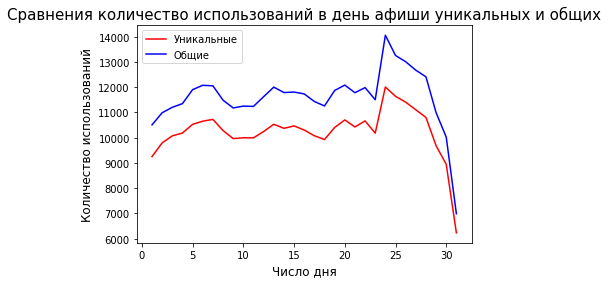

In [22]:
use_afisha_day_unig = visit.groupby('day').agg({'uid':'nunique'}).reset_index()
use_afisha_day_count = visit.groupby('day').agg({'uid':['count']}).reset_index()
display(use_afisha_day_unig)
#display(int(use_afisha_day_unig))
display(use_afisha_day_unig.describe())
use_afisha_day_mean = use_afisha_day_unig['uid'].mean()
display(use_afisha_day_mean)
plt.plot(use_afisha_day_unig['day'], use_afisha_day_unig['uid'], '-r');
plt.plot(use_afisha_day_count['day'], use_afisha_day_count['uid']['count'], '-b');
plt.title('Сравнения количество использований в день афиши уникальных и общих', fontsize=15, color='black')
plt.xlabel('Число дня',fontsize=12, color='black')
plt.ylabel('Количество использований',fontsize=12, color='black')
plt.legend(['Уникальные', 'Общие'])
plt.show()

## Вывод: видим всплески увеличения использования афиши в начале и ближе к концу месяца. Думаю что всплеск в 20 - тых числах месяца обусловлен получением зарплаты люди начинают больше средств тратить на развлечение.

## Сколько людей пользуются в неделю

,week,uid
,,nunique
0,1,6918
1,2,6703
2,3,6972
3,4,7060
4,5,8111


,week,uid
,,nunique
count,52.000000,52.000000
mean,26.500000,5825.288462
std,15.154757,2004.308969
min,1.000000,2364.000000
25%,13.750000,4128.750000
50%,26.500000,6233.000000
75%,39.250000,7420.750000
max,52.000000,10586.000000


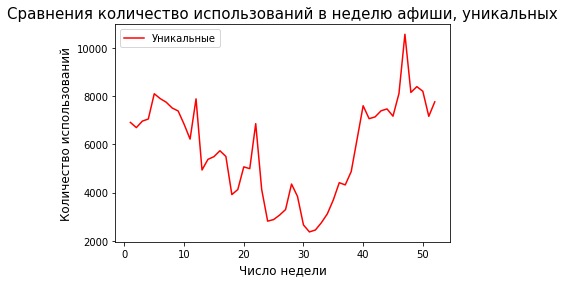

In [23]:
use_afisha_week = visit.groupby('week').agg({'uid':['nunique']}).reset_index()
display(use_afisha_week.head())
display(use_afisha_week.describe())
plt.plot(use_afisha_week['week'], use_afisha_week['uid']['nunique'], '-r');
#plt.plot(use_afisha_month_count['month'], use_afisha_month_count['uid']['count'], '-b');
plt.title('Сравнения количество использований в неделю афиши, уникальных', fontsize=15, color='black')
plt.xlabel('Число недели',fontsize=12, color='black')
plt.ylabel('Количество использований',fontsize=12, color='black')
plt.legend(['Уникальные', 'Общие'])
plt.show()

## Вывод: видим всплески увеличения использования афиши  ближе к концу года. Длинные новогодние праздники увеличивают посещение мероприятий людьми.

## Сколько людей пользуются в месяц

,month,uid
,,nunique
0,1,28716
1,2,28749
2,3,27473
3,4,21008
4,5,20701
5,6,13259
6,7,14183
7,8,11631
8,9,18975


,month,uid
,,nunique
count,12.000000,12.000000
mean,6.500000,23228.416667
std,3.605551,7546.380462
min,1.000000,11631.000000
25%,3.750000,17777.000000
50%,6.500000,24240.500000
75%,9.250000,28984.750000
max,12.000000,32797.000000


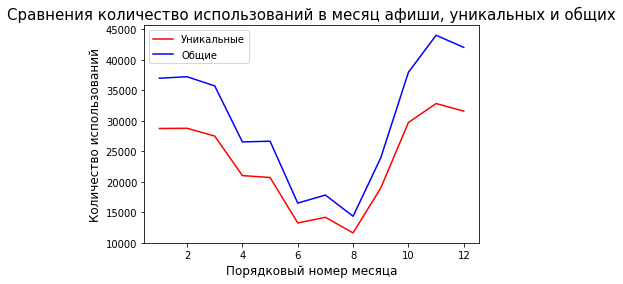

In [24]:
use_afisha_month_unig = visit.groupby('month').agg({'uid':['nunique']}).reset_index()
use_afisha_month_count = visit.groupby('month').agg({'uid':['count']}).reset_index()
display(use_afisha_month_unig.head(12))
display(use_afisha_month_unig.describe())
plt.plot(use_afisha_month_unig['month'], use_afisha_month_unig['uid']['nunique'], '-r');
plt.plot(use_afisha_month_count['month'], use_afisha_month_count['uid']['count'], '-b');
plt.title('Сравнения количество использований в месяц афиши, уникальных и общих', fontsize=15, color='black')
plt.xlabel('Порядковый номер месяца',fontsize=12, color='black')
plt.ylabel('Количество использований',fontsize=12, color='black')
plt.legend(['Уникальные', 'Общие'])
plt.show()

## Вывод:  видим всплески увеличения использования афиши  осенью и зимой , особенно в новогоднии праздники, когда люди находяться дома. В период же сезона отпусков посещение афиши падает.

## Сколько сессий в день?


,day,uid
,,count
0,1,10505
1,2,10985
2,3,11200
3,4,11346
4,5,11899


,day,uid
,,count
count,31.000000,31.000000
mean,16.000000,11593.548387
std,9.092121,1158.731745
min,1.000000,6988.000000
25%,8.500000,11241.500000
50%,16.000000,11730.000000
75%,23.500000,12024.500000
max,31.000000,14051.000000


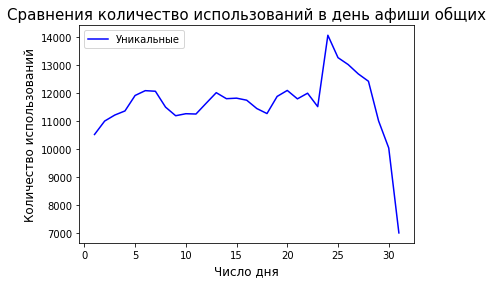

In [25]:
use_afisha_day_count = visit.groupby('day').agg({'uid':['count']}).reset_index()
display(use_afisha_day_count.head())
display(use_afisha_day_count.describe())
#plt.plot(use_afisha_day_count['day'], use_afisha_day_unig['uid'], '-r');
plt.plot(use_afisha_day_count['day'], use_afisha_day_count['uid']['count'], '-b');
plt.title('Сравнения количество использований в день афиши общих', fontsize=15, color='black')
plt.xlabel('Число дня',fontsize=12, color='black')
plt.ylabel('Количество использований',fontsize=12, color='black')
plt.legend(['Уникальные', 'Общие'])
plt.show()

## Вывод: ну собственно это мы уже видели.....видим всплески увеличения использования афиши в начале и ближе к концу месяца. Думаю что всплеск в 20 - тых числах месяца обусловлен получением зарплаты люди начинают больше средств тратить на развлечение.

## Сколько длится одна сессия?


In [26]:
display(visit.head())

,device,end_ts,source_id,start_ts,uid,day,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,27,52,12,2017


**добавляем столбец с длительностью сессии**

In [27]:
visit['duration'] = visit['end_ts'] - visit['start_ts']
#visit['duration_sec'] = visit['duration'].dt.minute
display(visit.head())

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,00:18:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,00:28:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017,00:00:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018,00:24:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,27,52,12,2017,00:00:00


In [28]:
visit['duration'].describe()

count                    359400
mean     0 days 00:10:43.025687
std      0 days 00:16:37.127760
min           -1 days +23:14:00
25%             0 days 00:02:00
50%             0 days 00:05:00
75%             0 days 00:14:00
max             0 days 11:51:00
Name: duration, dtype: object

**видим что гдето есть конец сесии больше чем начало сесии**  
вычисляем где

In [29]:
display(visit[visit['end_ts'] < visit['start_ts']])

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,25,12,3,2018,-1 days +23:28:00
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,25,12,3,2018,-1 days +23:14:00


**удаляем эти строки чтобы не портили нам статистику**

In [30]:
visit.drop([4181, 177972], inplace=True)
display(visit[visit['end_ts'] < visit['start_ts']])

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration


**проверяем**

In [31]:
visit['duration'].describe()

count                    359398
mean     0 days 00:10:43.042287
std      0 days 00:16:37.105211
min             0 days 00:00:00
25%             0 days 00:02:00
50%             0 days 00:05:00
75%             0 days 00:14:00
max             0 days 11:51:00
Name: duration, dtype: object

In [32]:
display(visit.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359398 entries, 0 to 359399
Data columns (total 10 columns):
device       359398 non-null object
end_ts       359398 non-null datetime64[ns]
source_id    359398 non-null int64
start_ts     359398 non-null datetime64[ns]
uid          359398 non-null uint64
day          359398 non-null int64
week         359398 non-null int64
month        359398 non-null int64
year         359398 non-null int64
duration     359398 non-null timedelta64[ns]
dtypes: datetime64[ns](2), int64(5), object(1), timedelta64[ns](1), uint64(1)
memory usage: 30.2+ MB


None

**видим 35 794 посещений с нулевой продолжительностью**

In [33]:
display(visit[visit['duration'] == '00:00:00'].count())

device       35794
end_ts       35794
source_id    35794
start_ts     35794
uid          35794
day          35794
week         35794
month        35794
year         35794
duration     35794
dtype: int64

In [34]:
display(visit.head(2))

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,00:18:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,00:28:00


In [35]:
display(visit.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359398 entries, 0 to 359399
Data columns (total 10 columns):
device       359398 non-null object
end_ts       359398 non-null datetime64[ns]
source_id    359398 non-null int64
start_ts     359398 non-null datetime64[ns]
uid          359398 non-null uint64
day          359398 non-null int64
week         359398 non-null int64
month        359398 non-null int64
year         359398 non-null int64
duration     359398 non-null timedelta64[ns]
dtypes: datetime64[ns](2), int64(5), object(1), timedelta64[ns](1), uint64(1)
memory usage: 30.2+ MB


None

#### Добавим столбец с количеством минут

In [36]:
visit['duration_min_int'] = visit['duration'].dt.total_seconds().div(60).astype(int)

In [37]:
display(visit.head(5))

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration,duration_min_int
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,00:18:00,18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,00:28:00,28
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017,00:00:00,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018,00:24:00,24
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,27,52,12,2017,00:00:00,0


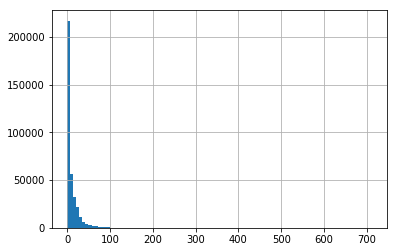

In [38]:
visit['duration_min_int'].hist(bins=100);

0   00:01:00
dtype: timedelta64[ns]

count                    359398
mean     0 days 00:10:43.042287
std      0 days 00:16:37.105211
min             0 days 00:00:00
25%             0 days 00:02:00
50%             0 days 00:05:00
75%             0 days 00:14:00
max             0 days 11:51:00
Name: duration, dtype: object

,duration
0,00:01:00


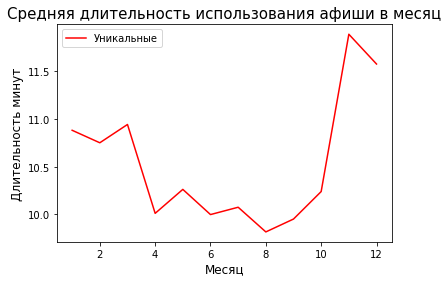

In [39]:
use_afisha_duration = visit.groupby('month').agg({'duration_min_int':'mean'}).reset_index()
#use_afisha_duration_median = visit.groupby('month').agg({'duration_min_int':'mode'})
display(visit['duration'].mode())
display(visit['duration'].describe())
display((visit[visit['month'] == 10][['duration']].mode()))
#display(use_afisha_duration.head())
#display(use_afisha_duration.describe())
#display(use_afisha_duration_median.head())
#display(use_afisha_duration_median.describe())
#plt.plot(use_afisha_day_count['day'], use_afisha_day_unig['uid'], '-r');
plt.plot(use_afisha_duration['month'], use_afisha_duration['duration_min_int'], '-r');
#plt.plot(use_afisha_duration_median['month'],use_afisha_duration_median['duration_min_int'], '-b');
plt.title('Средняя длительность использования афиши в месяц', fontsize=15, color='black')
plt.xlabel('Месяц',fontsize=12, color='black')
plt.ylabel('Длительность минут',fontsize=12, color='black')
plt.legend(['Уникальные', 'Общие'])
plt.show()

## Вывод:  видим всплески увеличения использования афиши  осенью и зимой , особенно в новогоднии праздники, когда люди находяться дома. В период же сезона отпусков посещение афиши падает.

In [40]:
def mode_r(a):
    for i in range(1, a):
        display('Наиболее распостраненный промежуток времени который пользователи проводят в Афише в ', i , 'месяце' ,(visit[visit['month'] == i][['duration']].mode()))

In [41]:
mode_r(13)

'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

1

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

2

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

3

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

4

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

5

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

6

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

7

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

8

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

9

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

10

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

11

'месяце'

,duration
0,00:01:00


'Наиболее распостраненный промежуток времени который пользователи проводят в Афише в '

12

'месяце'

,duration
0,00:01:00


## Вывод:  
### - видим всплески увеличения использования афиши  осенью и зимой , особенно в новогоднии праздники, когда люди находяться дома. В период же сезона отпусков посещение афиши падает.
### - наиболее распостраненнним временем которое пользователи проводять в сервисе является одна минута


## Как часто люди возвращаются?


**Разобьем пользователей на когорты Возьмём дату, когда пользователь впервые проявил активность**

In [42]:
visit_first_activity_date = visit.groupby(['uid'])['start_ts'].min()
visit_first_activity_date.name = 'first_activity_date'
display(visit_first_activity_date.head())


uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_activity_date, dtype: datetime64[ns]

In [43]:
visit_first_activity_date_gr = visit.groupby('uid').agg({'start_ts':'min'}).reset_index()
#visit_first_activity_date.name = 'first_activity_date'
visit_first_activity_date_gr = visit_first_activity_date_gr.set_index('uid')
display(visit_first_activity_date_gr.head())


,start_ts
uid,
11863502262781,2018-03-01 17:27:00
49537067089222,2018-02-06 15:55:00
297729379853735,2017-06-07 18:47:00
313578113262317,2017-09-18 22:49:00
325320750514679,2017-09-30 14:29:00


**присоеденим эти  данные к исходной таблице**

In [44]:
visit = visit.join(visit_first_activity_date, on='uid')
display(visit.head())

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration,duration_min_int,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,00:18:00,18,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,00:28:00,28,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017,00:00:00,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018,00:24:00,24,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,27,52,12,2017,00:00:00,0,2017-12-27 14:06:00


**Обьеденим пользователей в когорты по месяцам посмотрим удержание по месяцам добавим столбец с месяцем когорты**

In [45]:
visit['activity_month'] = visit['start_ts'].astype('datetime64[M]') 
visit['first_activity_month'] = visit['first_activity_date'].astype('datetime64[M]')                                   
display(visit.head())

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration,duration_min_int,first_activity_date,activity_month,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,00:18:00,18,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,00:28:00,28,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017,00:00:00,0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018,00:24:00,24,2018-03-09 20:05:00,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,27,52,12,2017,00:00:00,0,2017-12-27 14:06:00,2017-12-01,2017-12-01


**Рассчитаем lifetime пользователя в рамках когорты**  
[_](https://praktikum.yandex.ru/trainer/data-analyst/lesson/8224744d-28a9-48ce-947b-98a5f30d3104/task/ca0da3ac-3234-474f-a63b-0fd72742ce2c/)

In [46]:
visit['cohort_lifetime'] = visit['activity_month'] - visit['first_activity_month']
# перведем время в целые месяцы
visit['cohort_lifetime'] = visit['cohort_lifetime'] / np.timedelta64(1,'M')
visit['cohort_lifetime'] = visit['cohort_lifetime'].round().astype('int')
display(visit.head())

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration,duration_min_int,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,00:18:00,18,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,00:28:00,28,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017,00:00:00,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018,00:24:00,24,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,27,52,12,2017,00:00:00,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


**Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определенный «месяц»:**

In [47]:
cohorts = visit.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 
display(cohorts.head())
display(cohorts.tail())

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


,first_activity_month,cohort_lifetime,uid
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760
77,2018-05-01,0,15273


**Чтобы найти Retention Rate «коэффициент удержания», нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующую неделю.**

**Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:**

In [48]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
display(initial_users_count) 

,first_activity_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [49]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
display(cohorts.head())

,first_activity_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


**Рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте:**

In [50]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
display(cohorts.head())

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


**Построим сводную таблицу и тепловую карту:**<a id="cell1"></a>

In [51]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
display(retention_pivot)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


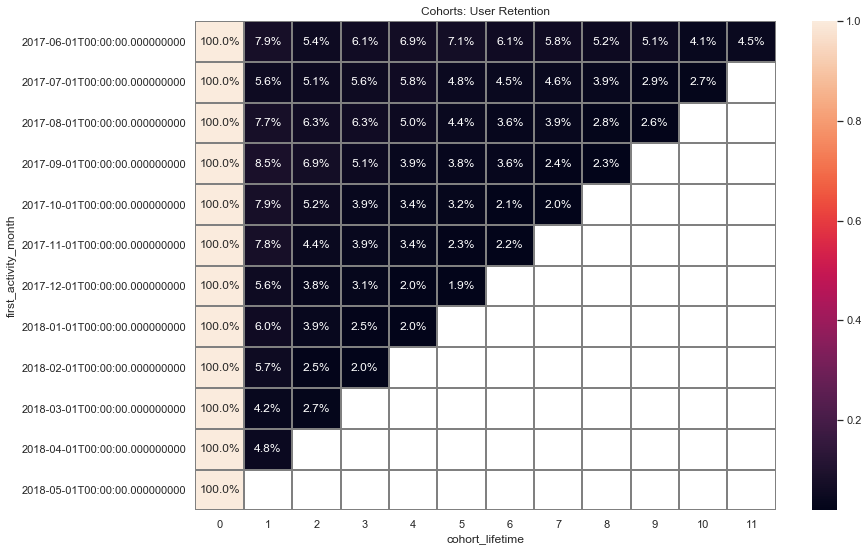

In [52]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');


**попробуем другое оформление**

Конкретно крассивая дата вот  
`yticklabels=retention_pivot.index.strftime('%Y.%m.%d')`  

размер шкалы  
`vmin = 0, vmax = 150,`

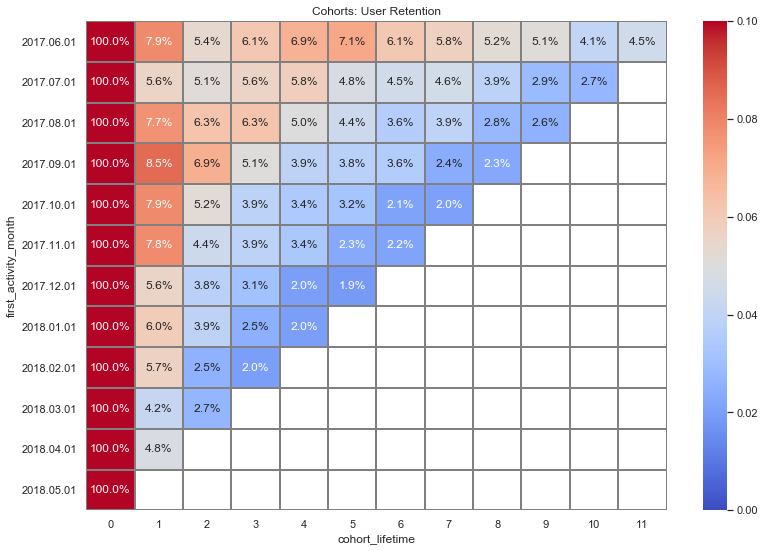

In [53]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0, vmax = 0.1, 
            cmap = 'coolwarm', yticklabels=retention_pivot.index.strftime('%Y.%m.%d'));

# Вывод: видим чем более позняя регистрация тем меньше пользователей у нас возвращается, также с течением времени процент возврата сильно уменьшается. Возможно есть проблема с длительным использованием сервиса клиентов что то не устраивает в его работе.

## Продажи

## Когда люди начинают покупать?


[_](https://praktikum.yandex.ru/trainer/data-analyst/lesson/756c5251-0c73-4268-95de-45bfe296697e/task/e8b66465-c9de-47df-ad20-4bdae344d25e/)

**Найдем длительность времени между первым посещением и первой покупкой - построим гистограмму, найдем среднее и медиану.**

In [54]:
display(visit.head())
display(order.head())

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration,duration_min_int,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,00:18:00,18,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,00:28:00,28,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017,00:00:00,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018,00:24:00,24,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,27,52,12,2017,00:00:00,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


**Сделаем сводную таблицу с первым посещением пользователя и ID пользователя**<a id="cell2"></a>

In [55]:
first_visit = visit.groupby(['uid']).agg({'start_ts':'min'}).reset_index()
display(first_visit.head())

,uid,start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


**соеденим с таблицей покупок по пользователю**

In [56]:
order = order.merge(first_visit,on='uid')
display(order.head())

,buy_ts,revenue,uid,start_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00


**добавим столбец с разницей между первым заходом и первой покупкой**

In [57]:
order['diff_first_buy'] = order['buy_ts'] - order['start_ts']
display(order.head())
display(order.info())

,buy_ts,revenue,uid,start_ts,diff_first_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,00:01:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,00:11:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,00:02:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,00:15:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,00:27:00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 5 columns):
buy_ts            50415 non-null datetime64[ns]
revenue           50415 non-null float64
uid               50415 non-null uint64
start_ts          50415 non-null datetime64[ns]
diff_first_buy    50415 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), timedelta64[ns](1), uint64(1)
memory usage: 2.3 MB


None

In [58]:
display(order['diff_first_buy'].describe())

count                      50415
mean     37 days 00:53:06.287414
std      70 days 14:39:40.373203
min              0 days 00:00:00
25%              0 days 00:06:00
50%              0 days 03:26:00
75%             38 days 09:22:30
max            364 days 08:29:00
Name: diff_first_buy, dtype: object

**Перведем время в целые минуты и перведем время в целые числа для построения гистограммы**<a id="cell3"></a>  
во временном формате гистограмма не строится????

In [59]:
# перведем время в целые минуты
#order['time_for_hist'] = order['diff_first_buy'] / np.timedelta64(1,'m')
# и перведем время в целые числа
#order['time_for_hist'] = order['time_for_hist'].round().astype('int')

**или так, переведем**

In [60]:
order['time_for_hist'] = order['diff_first_buy'].dt.total_seconds().div(60).astype(int)

In [61]:
display(order.head())
display(order.tail())

,buy_ts,revenue,uid,start_ts,diff_first_buy,time_for_hist
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,00:01:00,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,00:11:00,11
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,00:02:00,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,00:15:00,15
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,00:27:00,27


,buy_ts,revenue,uid,start_ts,diff_first_buy,time_for_hist
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,0 days 14:39:00,879
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,0 days 00:45:00,45
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,0 days 00:02:00,2
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,220 days 11:24:00,317484
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-05-31 23:59:00,0 days 00:03:00,3


Text(0.5, 0, 'Разница времени между первым посещением и первой покупкой мин.')

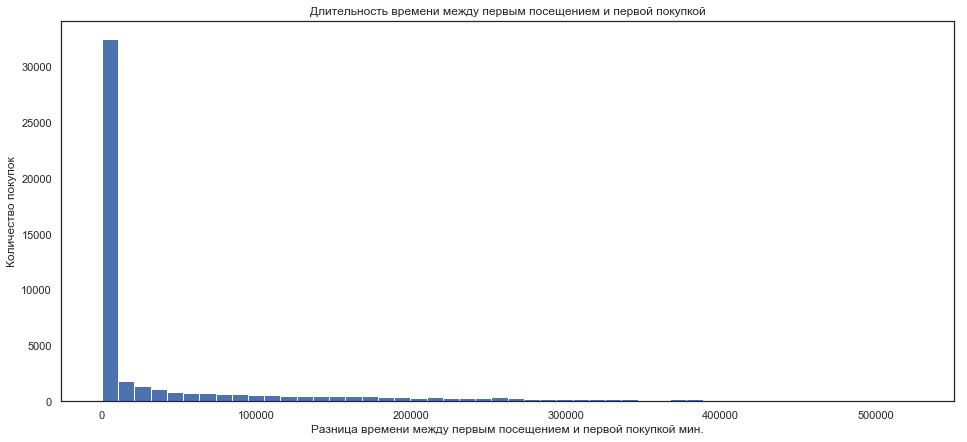

In [62]:
plt.figure(figsize=(16, 7))
plt.hist(order['time_for_hist'], bins=50)
plt.title('Длительность времени между первым посещением и первой покупкой')
plt.ylabel('Количество покупок')
plt.xlabel('Разница времени между первым посещением и первой покупкой мин.')

# Вывод:
### - основное количество покупок происходит в течении 5000 минут = 3 - 4 дней

## Сколько раз покупают за период?


In [63]:
display(order.head())

,buy_ts,revenue,uid,start_ts,diff_first_buy,time_for_hist
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,00:01:00,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,00:11:00,11
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,00:02:00,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,00:15:00,15
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,00:27:00,27


In [64]:
order_buy_period = order[['buy_ts','uid']]
display(order_buy_period.head() )

,buy_ts,uid
0,2017-06-01 00:10:00,10329302124590727494
1,2017-06-01 00:25:00,11627257723692907447
2,2017-06-01 00:27:00,17903680561304213844
3,2017-06-01 00:29:00,16109239769442553005
4,2017-06-01 07:58:00,14200605875248379450


**добавим столбцы с периодами**

In [65]:
order_buy_period['buy_year']  = order_buy_period['buy_ts'].dt.year
order_buy_period['buy_month'] = order_buy_period['buy_ts'].dt.month
order_buy_period['buy_week']  = order_buy_period['buy_ts'].dt.week
order_buy_period['buy_date'] = order_buy_period['buy_ts'].dt.date
display(order_buy_period.head() )

,buy_ts,uid,buy_year,buy_month,buy_week,buy_date
0,2017-06-01 00:10:00,10329302124590727494,2017,6,22,2017-06-01
1,2017-06-01 00:25:00,11627257723692907447,2017,6,22,2017-06-01
2,2017-06-01 00:27:00,17903680561304213844,2017,6,22,2017-06-01
3,2017-06-01 00:29:00,16109239769442553005,2017,6,22,2017-06-01
4,2017-06-01 07:58:00,14200605875248379450,2017,6,22,2017-06-01


### Сколько раз покупают в неделю

In [66]:
order_buy_period_week = order_buy_period.groupby(['buy_year','buy_month','buy_week']).agg({'uid':'count'})
display(order_buy_period_week.head())

uid
buy_year buy_month buy_week     
2017     6         22        340
                   23        938
                   24        343
                   25        371
                   26        362

In [67]:
order_buy_period_week = order_buy_period.groupby(['buy_year','buy_month','buy_week']).agg({'uid':'count'}).reset_index()

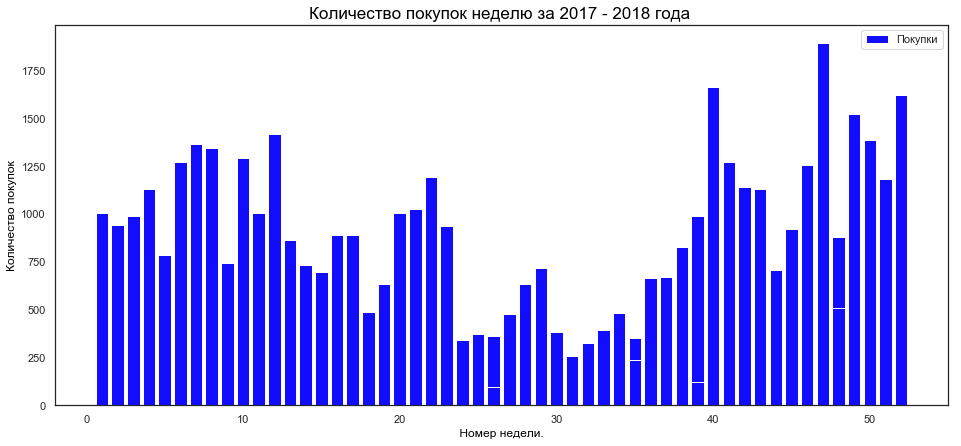

In [68]:
plt.figure(figsize=(16, 7))
plt.bar(order_buy_period_week['buy_week'], order_buy_period_week['uid'], color=(0.07, 0.05, 1));
plt.title('Количество покупок неделю за 2017 - 2018 года ', fontsize=17, color='black')
plt.xlabel(' Номер недели. ',fontsize=12, color='black')
plt.ylabel('Количество покупок',fontsize=12, color='black')
plt.legend([ 'Покупки']);


## Вывод:  видим всплески увеличения использования афиши  осенью и зимой , особенно в новогоднии праздники, когда люди находяться дома. В период же сезона отпусков посещение афиши падает.

### Сколько раз покупают в месяц

In [69]:
order_buy_period_month = order_buy_period.groupby(['buy_year','buy_month']).agg({'uid':'count'})
display(order_buy_period_week.head())

,buy_year,buy_month,buy_week,uid
0,2017,6,22,340
1,2017,6,23,938
2,2017,6,24,343
3,2017,6,25,371
4,2017,6,26,362


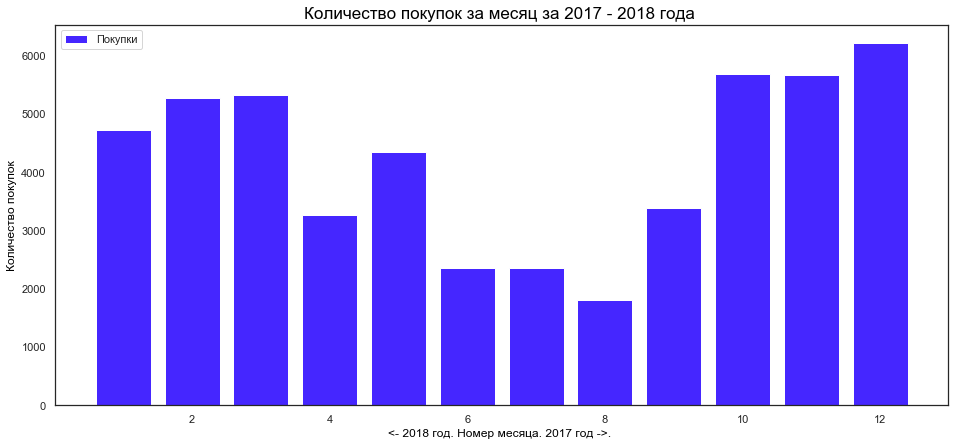

In [70]:
order_buy_period_month = order_buy_period.groupby(['buy_year','buy_month']).agg({'uid':'count'}).reset_index()
plt.figure(figsize=(16, 7))
plt.bar(order_buy_period_month['buy_month'], order_buy_period_month['uid'], color=(0.27, 0.15, 1));
plt.title('Количество покупок за месяц за 2017 - 2018 года ', fontsize=17, color='black')
plt.xlabel('<- 2018 год. Номер месяца. 2017 год ->. ',fontsize=12, color='black')
plt.ylabel('Количество покупок',fontsize=12, color='black')
plt.legend([ 'Покупки']);


<div class="alert alert-info">
    <strong>Хорошо бы узнать среднее число покупок на 1 клиента за какой-то период времени, например пол года</strong> </div>

**Оставим только первые 6 месяцев в талице**

In [71]:
order_buy_six = order_buy_period[order_buy_period['buy_month'] <= 6]
display(order_buy_six.head())

,buy_ts,uid,buy_year,buy_month,buy_week,buy_date
0,2017-06-01 00:10:00,10329302124590727494,2017,6,22,2017-06-01
1,2017-06-01 00:25:00,11627257723692907447,2017,6,22,2017-06-01
2,2017-06-01 00:27:00,17903680561304213844,2017,6,22,2017-06-01
3,2017-06-01 00:29:00,16109239769442553005,2017,6,22,2017-06-01
4,2017-06-01 07:58:00,14200605875248379450,2017,6,22,2017-06-01


In [72]:
display('Cреднее число покупок на 1 клиента за пол года', order_buy_six['uid'].count()/order_buy_six['uid'].nunique() )

'Cреднее число покупок на 1 клиента за пол года'

1.3101698425849213

## Вывод:  видим всплески увеличения использования афиши  осенью и зимой , особенно в новогоднии праздники, когда люди находяться дома. В период же сезона отпусков посещение афиши падает.

## Как меняется средний чек
[ссылка на доп информацию](https://praktikum.yandex.ru/trainer/data-analyst/lesson/8224744d-28a9-48ce-947b-98a5f30d3104/task/ca0da3ac-3234-474f-a63b-0fd72742ce2c/)


In [73]:
display(order.head())

,buy_ts,revenue,uid,start_ts,diff_first_buy,time_for_hist
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,00:01:00,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,00:11:00,11
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,00:02:00,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,00:15:00,15
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,00:27:00,27


**Создадим таблицу без ненужных строк**

In [74]:
order_aver_bill = order[['buy_ts', 'revenue','uid']]
display(order_aver_bill.head())

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


**создадим когорты покупателей по первой покупке**

In [75]:

order_aver_bill_first = order_aver_bill.groupby('uid')['buy_ts'].min()
order_aver_bill_first.name = 'first_order_date'
display(order_aver_bill_first.head())

uid
313578113262317    2018-01-03 21:51:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
Name: first_order_date, dtype: datetime64[ns]

**приаттачим их к таблице по пользователю**

In [76]:
order_aver_bill = order_aver_bill.join(order_aver_bill_first, on='uid')
display(order_aver_bill.head())

,buy_ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


**преобразуем поля в месяцы**

In [77]:
order_aver_bill['first_order_month'] = order_aver_bill['first_order_date'].astype('datetime64[M]')
order_aver_bill['order_month'] = order_aver_bill['buy_ts'].astype('datetime64[M]')
display(order_aver_bill.head())

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


**Делаем сводную талицу сколько потратил каждый покупатель сортируем по когортам**

In [78]:
cohorts_order_aver_bill = order_aver_bill.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum', 'uid':'nunique'})
display(cohorts_order_aver_bill.head())

revenue   uid
first_order_month order_month               
2017-06-01        2017-06-01   9557.49  2023
                  2017-07-01    981.82    61
                  2017-08-01    885.34    50
                  2017-09-01   1931.30    54
                  2017-10-01   2068.58    88

**Найдём средний чек покупателя revenue_per_user — разделим показатель revenue на uid  
и добавим столбец со средним чеком**

In [79]:
cohorts_order_aver_bill['revenue_per_user'] = cohorts_order_aver_bill['revenue'] / cohorts_order_aver_bill['uid'] 
display(cohorts_order_aver_bill.head())

revenue   uid  revenue_per_user
first_order_month order_month                                 
2017-06-01        2017-06-01   9557.49  2023          4.724414
                  2017-07-01    981.82    61         16.095410
                  2017-08-01    885.34    50         17.706800
                  2017-09-01   1931.30    54         35.764815
                  2017-10-01   2068.58    88         23.506591

**Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, как изменяется средний чек с течением времени**

In [80]:
cohorts_order_aver_bill.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean') 

order_month,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


**Чтобы оценить, как изменяется средний чек в зависимости от времени, прошедшего с момента первой покупки  
Для когорты покупателей такой показатель называют lifetime (англ. «время жизни»).  
Эта метрика для каждого события отображает, в каком по счёту месяце от месяца когорты оно произошло.**  


In [81]:
cohorts_order_aver_bill=cohorts_order_aver_bill.reset_index()
display(cohorts_order_aver_bill.head())

,first_order_month,order_month,revenue,uid,revenue_per_user
0,2017-06-01,2017-06-01,9557.49,2023,4.724414
1,2017-06-01,2017-07-01,981.82,61,16.095410
2,2017-06-01,2017-08-01,885.34,50,17.706800
3,2017-06-01,2017-09-01,1931.30,54,35.764815
4,2017-06-01,2017-10-01,2068.58,88,23.506591


**Найдём lifetime когорты. Из месяца совершения заказа order_month вычтем месяц когорты first_order_month**

In [82]:
cohorts_order_aver_bill['cohort_lifetime'] = cohorts_order_aver_bill['order_month'] - cohorts_order_aver_bill['first_order_month']
display(cohorts_order_aver_bill.head())

,first_order_month,order_month,revenue,uid,revenue_per_user,cohort_lifetime
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0 days
1,2017-06-01,2017-07-01,981.82,61,16.095410,30 days
2,2017-06-01,2017-08-01,885.34,50,17.706800,61 days
3,2017-06-01,2017-09-01,1931.30,54,35.764815,92 days
4,2017-06-01,2017-10-01,2068.58,88,23.506591,122 days


**приведем cohort_lifetime к числу порядковому номеру месяца в каком произошло событие**


In [83]:
cohorts_order_aver_bill['cohort_lifetime'] = (cohorts_order_aver_bill['cohort_lifetime'] 
                                              / np.timedelta64(1,'M')).round().astype('int')
display(cohorts_order_aver_bill.head())

,first_order_month,order_month,revenue,uid,revenue_per_user,cohort_lifetime
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,61,16.095410,1
2,2017-06-01,2017-08-01,885.34,50,17.706800,2
3,2017-06-01,2017-09-01,1931.30,54,35.764815,3
4,2017-06-01,2017-10-01,2068.58,88,23.506591,4


In [84]:
cohort_lifetime_order_aver_bill = cohorts_order_aver_bill.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')
display(cohort_lifetime_order_aver_bill)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07-01,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09-01,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10-01,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11-01,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Построим тепловую таблицу**

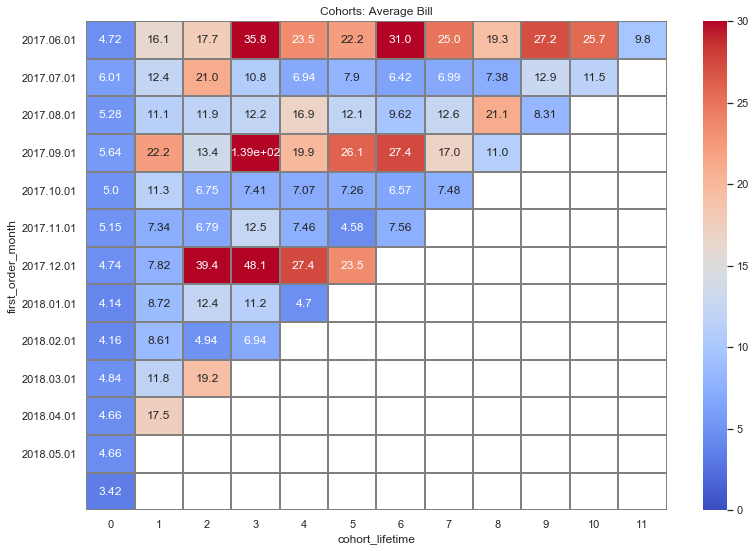

In [85]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Average Bill')
sns.heatmap(cohort_lifetime_order_aver_bill, annot=True, fmt='.3', linewidths=1, linecolor='gray', vmin = 0, vmax = 30, 
            cmap = 'coolwarm', yticklabels=retention_pivot.index.strftime('%Y.%m.%d'));

# Вывод: в основном мы видим увеличение среднего чека после начала использования сервиса и резкое падение его к концу срока выборки

In [86]:
display(cohorts_order_aver_bill.head())

,first_order_month,order_month,revenue,uid,revenue_per_user,cohort_lifetime
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,61,16.095410,1
2,2017-06-01,2017-08-01,885.34,50,17.706800,2
3,2017-06-01,2017-09-01,1931.30,54,35.764815,3
4,2017-06-01,2017-10-01,2068.58,88,23.506591,4


**Сделаем сводную таблицу по месяцам с общей выручкой и количеством покупателей, добавим столбец со средним чеком**

,first_order_month,revenue,uid,aver_bill_month
0,2017-06-01,24031.69,2653,9.058308
1,2017-07-01,16127.92,2348,6.868790
2,2017-08-01,11606.26,1721,6.743905
3,2017-09-01,34676.32,3147,11.018850
4,2017-10-01,27603.45,5049,5.467112
5,2017-11-01,26098.99,4720,5.529447
6,2017-12-01,33485.74,4842,6.915684
7,2018-01-01,16663.13,3658,4.555257
8,2018-02-01,16750.50,3866,4.332773
9,2018-03-01,19273.41,3681,5.235917


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
first_order_month    13 non-null datetime64[ns]
revenue              13 non-null float64
uid                  13 non-null int64
aver_bill_month      13 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 496.0 bytes


None

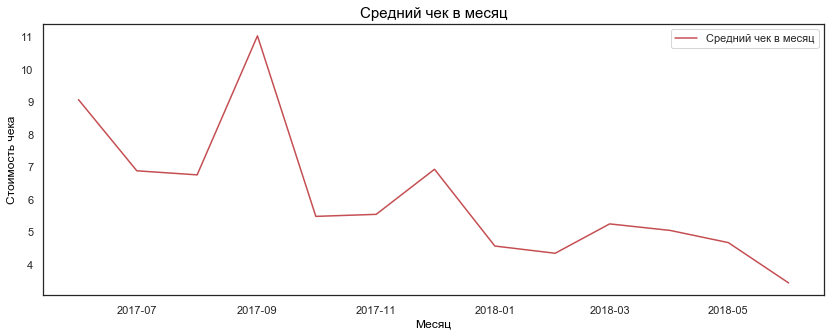

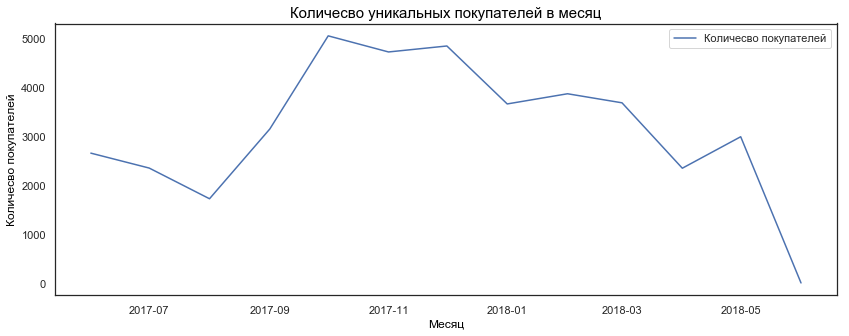

In [87]:
cohorts_order_aver_bill_one = cohorts_order_aver_bill.groupby('first_order_month').agg({'revenue':'sum','uid':'sum'}).reset_index()
cohorts_order_aver_bill_one['aver_bill_month'] = cohorts_order_aver_bill_one['revenue']/cohorts_order_aver_bill_one['uid']
display(cohorts_order_aver_bill_one)
display(cohorts_order_aver_bill_one.info())
plt.figure(figsize=(14, 5))
plt.plot(cohorts_order_aver_bill_one['first_order_month'], cohorts_order_aver_bill_one['aver_bill_month'], '-r')
#plt.plot(cohorts_order_aver_bill_one['first_order_month'], cohorts_order_aver_bill_one['uid'], '-b')
plt.title('Средний чек в месяц', fontsize=15, color='black')
plt.xlabel('Месяц',fontsize=12, color='black')
plt.ylabel('Стоимость чека',fontsize=12, color='black')
plt.legend(['Средний чек в месяц'])
plt.show()

plt.figure(figsize=(14, 5))
#plt.plot(cohorts_order_aver_bill_one['first_order_month'], cohorts_order_aver_bill_one['aver_bill_month'], '-r')
plt.plot(cohorts_order_aver_bill_one['first_order_month'], cohorts_order_aver_bill_one['uid'], '-b')
plt.title('Количесво уникальных покупателей в месяц', fontsize=15, color='black')
plt.xlabel('Месяц',fontsize=12, color='black')
plt.ylabel('Количесво покупателей',fontsize=12, color='black')
plt.legend(['Количесво покупателей'])
plt.show()

# Вывод:  со временем мы видим тенденцию к падению среднего чека  и количества покупателей, но к новогодним праздникам количество новых покупателей растет

## Сколько денег приносят? (LTV)
[-](https://praktikum.yandex.ru/trainer/data-analyst/lesson/866a6e6c-b9d9-495d-8815-1b42dfd4255f/task/d445cea6-6ca2-47c9-9cf5-134141fb1719/)


**Посмотрим на распределение дат заказов**

In [88]:
display(order.head())

,buy_ts,revenue,uid,start_ts,diff_first_buy,time_for_hist
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,00:01:00,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,00:11:00,11
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,00:02:00,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,00:15:00,15
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,00:27:00,27


In [89]:
order['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [90]:
display(cost.head(1))

,source_id,data,costs
0,1,2017-06-01,75.2


In [91]:
cost['data'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: data, dtype: object

In [92]:
cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
data         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


**Прикинем маржинальность Афиши за указанный период**

In [93]:
display('Валовый доход -',order['revenue'].sum())
display('Расходы на маркетинг -',cost['costs'].sum())
marja_afish = order['revenue'].sum() - cost['costs'].sum()
display('Прибыль/убыток -', marja_afish)

'Валовый доход -'

252057.2

'Расходы на маркетинг -'

329131.62

'Прибыль/убыток -'

-77074.41999999998

**пока видим работу в убыток**

**Сформируем месячные когорты**

In [94]:
order = order[['buy_ts', 'revenue', 'uid']]

In [95]:
order['order_month'] = order['buy_ts'].astype('datetime64[M]')
cost['month'] = cost['data'].astype('datetime64[M]') 
display(order.head(2))
display(cost.head(2))

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01


,source_id,data,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01


**месяц первой покупки каждого покупателя**

In [96]:
first_order = order.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_order.columns = ['uid', 'first_order_month']
display(first_order.head(2))

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01


**Посчитаем количество новых покупателей (n_buyers) за каждый месяц**

In [97]:
cohort_sizes = first_order.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
display(cohort_sizes.head())

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


**добавляем в таблицу вс заказами месяц первой покупки**

In [98]:
orders_new = pd.merge(order, first_order, on='uid')
display(orders_new.head(2))

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01


**Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку**

In [99]:
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
display(cohorts.head(2)) 
display(cohorts.info()) 

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 3 columns):
first_order_month    79 non-null datetime64[ns]
order_month          79 non-null datetime64[ns]
revenue              79 non-null float64
dtypes: datetime64[ns](2), float64(1)
memory usage: 1.9 KB


None

**сколько людей первый раз совершили покупку в каждый месяц**

In [100]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
display(report.head()) 

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


**нужно найти валовую прибыль, умножив выручку на маржинальность. Во-вторых, LTV — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты**

**Так как маржинальность не указана ставим 100%**

In [101]:
margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
display(report.head(2)) 

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1


**Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте**

In [102]:
report['ltv'] = report['gp'] / report['n_buyers']
display(report.head())

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531


In [103]:
ltv_cohorts = report.groupby('first_order_month').agg({'ltv': 'sum'}).reset_index()
display(ltv_cohorts)

,first_order_month,ltv
0,2017-06-01,11.879234
1,2017-07-01,8.386854
2,2017-08-01,8.471723
3,2017-09-01,13.435227
4,2017-10-01,6.360242
5,2017-11-01,6.395244
6,2017-12-01,7.639913
7,2018-01-01,4.940151
8,2018-02-01,4.587921
9,2018-03-01,5.455253


**Для наглядности визуализируем когорты в виде сводной таблицы**

<div class="alert alert-info">
    
**`output = output.cumsum(axis=1).round(2)` добавлено**     
    </div>

In [104]:
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output = output.cumsum(axis=1).round(2) 
display(output)
    

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


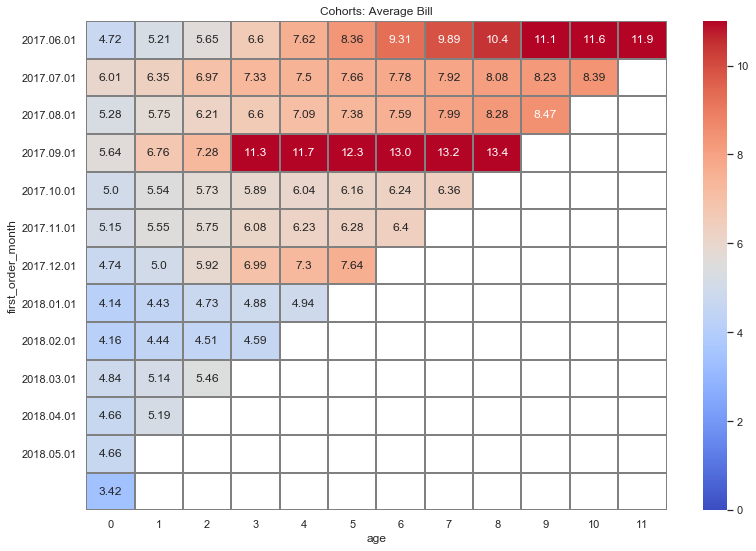

In [105]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Average Bill')
sns.heatmap(output, annot=True, fmt='.3', linewidths=1, linecolor='gray', vmin = 0, vmax = 11, 
            cmap = 'coolwarm', yticklabels=retention_pivot.index.strftime('%Y.%m.%d'));

**За год каждый покупатель в каждой когорте принес**

In [106]:
ltv_cohorts = report.groupby('first_order_month').agg({'ltv': 'sum'}).reset_index()

display(ltv_cohorts)
display(ltv_cohorts.info())

,first_order_month,ltv
0,2017-06-01,11.879234
1,2017-07-01,8.386854
2,2017-08-01,8.471723
3,2017-09-01,13.435227
4,2017-10-01,6.360242
5,2017-11-01,6.395244
6,2017-12-01,7.639913
7,2018-01-01,4.940151
8,2018-02-01,4.587921
9,2018-03-01,5.455253


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
first_order_month    13 non-null datetime64[ns]
ltv                  13 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 288.0 bytes


None

## График с датами <a id="cell4"></a>

<Figure size 1152x720 with 0 Axes>

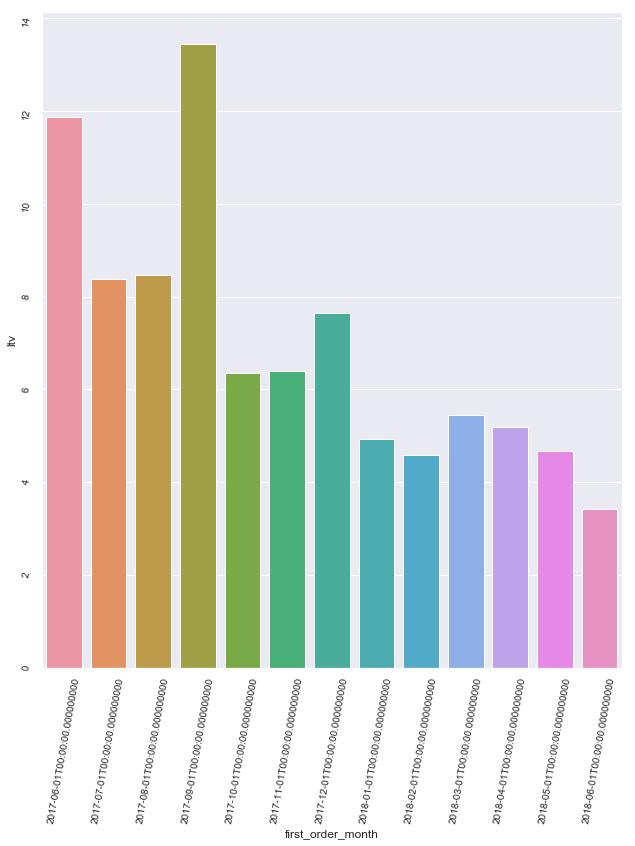

In [107]:
plt.figure(figsize=(16, 10))
sns.set_style('darkgrid')
sns.catplot(x='first_order_month', y='ltv', height=10, data=ltv_cohorts, kind='bar');
plt.xticks(rotation=80, fontsize=10)
plt.yticks(rotation=80, fontsize=10)
plt.show();

In [108]:
ltv_cohorts['first_order_month'] = ltv_cohorts['first_order_month'].dt.month
#ltv_cohorts['first_order_month'] = pd.to_datetime(ltv_cohorts['first_order_month'])


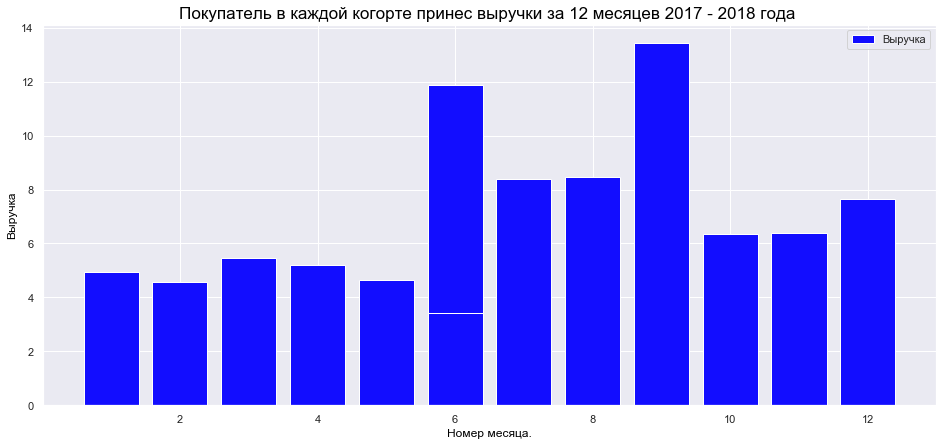

In [109]:
plt.figure(figsize=(16, 7))
plt.bar(ltv_cohorts['first_order_month'], ltv_cohorts['ltv'], color=(0.07, 0.05, 1));
plt.title('Покупатель в каждой когорте принес выручки за 12 месяцев 2017 - 2018 года ', fontsize=17, color='black')
plt.xlabel('Номер месяца.',fontsize=12, color='black')
plt.ylabel('Выручка',fontsize=12, color='black')
plt.legend([ 'Выручка']);


**проверяем**

In [110]:
ltv_2017_06_01 = output.loc['2017-06-01'].sum()
ltv_2017_07_01 = output.loc['2017-07-01'].sum()
print(ltv_2017_06_01) 
print(ltv_2017_07_01)

102.36
82.22


# Вывод:максимальную выручку покупатели приносят в первый месяц использования сервиса, потом выручка падает но бывают и всплески.

In [111]:
display(report.head())
display(report.info())

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531


<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 7 columns):
first_order_month    79 non-null datetime64[ns]
n_buyers             79 non-null int64
order_month          79 non-null datetime64[ns]
revenue              79 non-null float64
gp                   79 non-null float64
age                  79 non-null int32
ltv                  79 non-null float64
dtypes: datetime64[ns](2), float64(3), int32(1), int64(1)
memory usage: 4.6 KB


None

In [112]:
report_six_month = report[report['first_order_month'] <= '2017-11-01']
report_six_month = report_six_month[report_six_month['age'] <= 6]
display(report_six_month.head())

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531


In [113]:
output_six_month = report_six_month.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output_six_month = output_six_month.cumsum(axis=1).round(2) 
display(output_six_month)

age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40


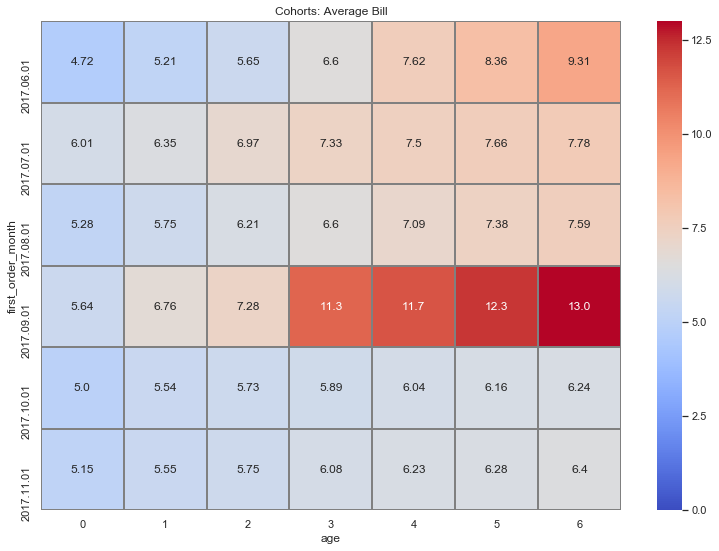

In [114]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Average Bill')
sns.heatmap(output_six_month, annot=True, fmt='.3', linewidths=1, linecolor='gray', vmin = 0, vmax = 13, 
            cmap = 'coolwarm', yticklabels=output_six_month.index.strftime('%Y.%m.%d'));

**За полгода каждый покупатель принес**

In [115]:
display(report_six_month.head())

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531


In [116]:
ltv_six_month = report_six_month.groupby('first_order_month').agg({'ltv': 'sum'}).reset_index()
display(ltv_six_month.info())
display(ltv_six_month)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
first_order_month    6 non-null datetime64[ns]
ltv                  6 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 176.0 bytes


None

,first_order_month,ltv
0,2017-06-01,9.310524
1,2017-07-01,7.780983
2,2017-08-01,7.586526
3,2017-09-01,13.008071
4,2017-10-01,6.244772
5,2017-11-01,6.395244


<Figure size 1152x720 with 0 Axes>

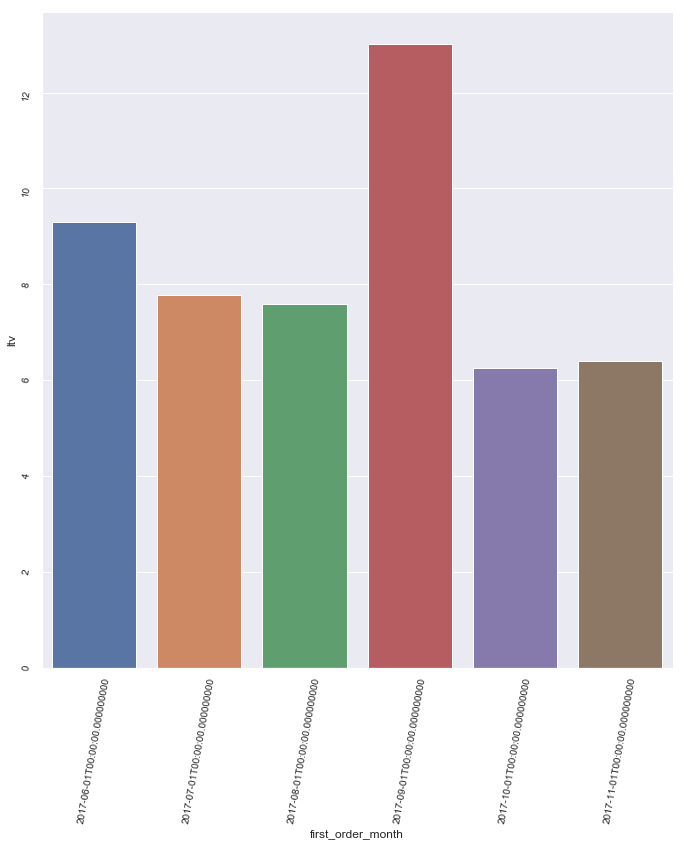

In [117]:
plt.figure(figsize=(16, 10))
sns.set_style('darkgrid')
sns.catplot(x='first_order_month', y='ltv', height=10, data=ltv_six_month, kind='bar');
plt.xticks(rotation=80, fontsize=10)
plt.yticks(rotation=80, fontsize=10)
plt.show();

In [118]:
#plt.figure(figsize=(16, 7))
#plt.bar(ltv_six_month['first_order_month'], ltv_six_month['ltv'], color=(0.67, 0.25, 1));
#plt.title('Покупатель в каждой когорте принес выручки за 6 месяцев года ', fontsize=17, color='black')
#plt.xlabel('Месяц.',fontsize=12, color='black')
#plt.ylabel('Выручка',fontsize=12, color='black')
#plt.legend([ 'Выручка']);


# Вывод: Видно падение выручки с течением времени, также наблюдаем странный всплеск повышения выручки с одного покупателя в сентябре 2017 года, возможно связано с какими то крупными еденичными покупками в этот период

# Маркетинг
### Сколько денег потратили всего 

In [119]:
display(cost.head(2))

,source_id,data,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01


In [120]:
display('Всего на маркетинг потратили - ', cost['costs'].sum())

'Всего на маркетинг потратили - '

329131.62

### Hа каждый источник

In [121]:
display(cost.groupby('source_id').agg({'costs':'sum'}))

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


### По времени

In [122]:
display(cost.groupby('month').agg({'costs':'sum'}))

,costs
month,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


### Сколько стоило привлечение одного посетителя из каждого источника?


**Построим сводные таблицы расходов на маркетинг на каждый источник**

In [123]:
cost_every_source = cost.groupby(['month', 'source_id']).agg({'costs':'sum'}).reset_index()
cost_every_source = cost_every_source.rename(columns={'month':'data'})
display(cost_every_source.head())
display(cost_every_source.info())
display(cost_every_source['costs'].sum())

,data,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
data         84 non-null datetime64[ns]
source_id    84 non-null int64
costs        84 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.0 KB


None

329131.61999999994

**Количество посетителей, приобретенных на каждую конкретную дату из каждого конкретного источника**

In [124]:
visit_date_source = visit.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first', 'start_ts': 'first'}).reset_index()
visit_date_source = visit_date_source.rename(columns={'start_ts':'data'})
visit_date_source['data'] = visit_date_source['data'].astype('datetime64[M]')
display(visit_date_source.head())
display(visit_date_source.info())

,uid,source_id,data
0,11863502262781,3,2018-03-01
1,49537067089222,2,2018-02-01
2,297729379853735,3,2017-06-01
3,313578113262317,2,2017-09-01
4,325320750514679,5,2017-09-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228169 entries, 0 to 228168
Data columns (total 3 columns):
uid          228169 non-null uint64
source_id    228169 non-null int64
data         228169 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), uint64(1)
memory usage: 5.2 MB


None

**Количество посетителей привлеченных из конкретного источника с разбивкой по месяцам**

In [125]:
visit_count_uid = visit_date_source.groupby(['data','source_id']).agg({'uid':'nunique'}).reset_index()
display(visit_count_uid.head())
print()
display('Cумма расходов на маркетинг на каждый источник' , cost_every_source.head())
display( visit_count_uid.info())

,data,source_id,uid
0,2017-06-01,1,631
1,2017-06-01,2,1262
2,2017-06-01,3,4080
3,2017-06-01,4,3447
4,2017-06-01,5,2728


'Cумма расходов на маркетинг на каждый источник'

,data,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 3 columns):
data         98 non-null datetime64[ns]
source_id    98 non-null int64
uid          98 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.4 KB


None

**Соеденим таблицы количества посетителей из каждого источника и суммы расходов на них**

In [126]:
costs_to_client = pd.merge(visit_count_uid, cost_every_source, on=['source_id', 'data'])
display(costs_to_client.head())
#display(costs_to_client.info())

,data,source_id,uid,costs
0,2017-06-01,1,631,1125.61
1,2017-06-01,2,1262,2427.38
2,2017-06-01,3,4080,7731.65
3,2017-06-01,4,3447,3514.80
4,2017-06-01,5,2728,2616.12


**Вставляем столбец стоимость привлечения одного клиента**

In [127]:
costs_to_one_client = costs_to_client.groupby('source_id').agg({'uid':'sum', 'costs':'sum'}).reset_index()
costs_to_one_client['attracting_one_buyer'] = costs_to_client['costs']/costs_to_client['uid']
costs_to_one_client = costs_to_one_client.sort_values(by='attracting_one_buyer', ascending=False)
display(costs_to_one_client.head(10))

,source_id,uid,costs,attracting_one_buyer
1,2,17616,42806.04,1.923439
2,3,66116,141321.63,1.895012
0,1,9469,20833.27,1.783851
3,4,72346,61073.60,1.019669
4,5,49237,51757.10,0.958988
6,10,6903,5822.49,0.793485
5,9,6448,5517.49,0.400028


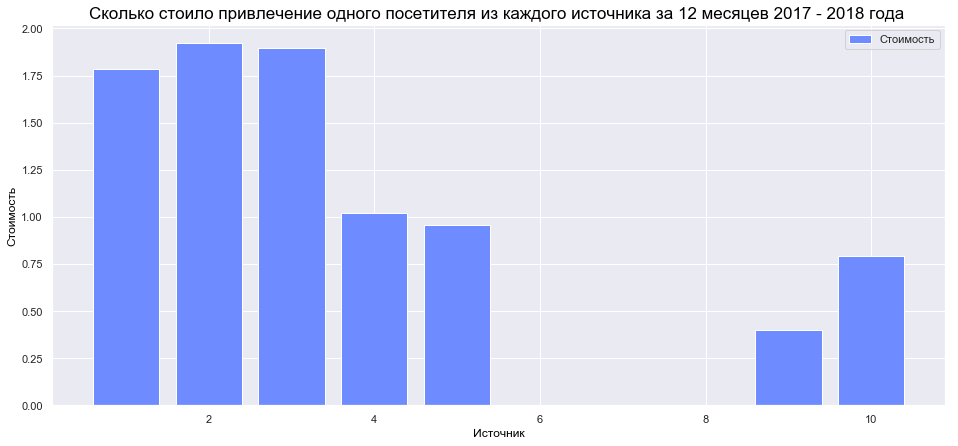

In [128]:
plt.figure(figsize=(16, 7))
plt.bar(costs_to_one_client['source_id'], costs_to_one_client['attracting_one_buyer'], color=(0.43, 0.55, 1));
plt.title('Сколько стоило привлечение одного посетителя из каждого источника за 12 месяцев 2017 - 2018 года ', fontsize=17, color='black')
plt.xlabel('Источник',fontsize=12, color='black')
plt.ylabel('Стоимость',fontsize=12, color='black')
plt.legend([ 'Стоимость']);


# Вывод: наименьшие затраты на привлечение одного покупателя у нас имеют источники 9 и 10

In [129]:
display('visit', visit.head(2))
display('cost',cost.head(2))
display('order',order.head(2))

'visit'

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration,duration_min_int,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,00:18:00,18,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,00:28:00,28,2018-02-19 16:53:00,2018-02-01,2018-02-01,0


'cost'

,source_id,data,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01


'order'

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01


In [130]:
# покупатели по каналам
visits_sorted = visit.sort_values(by='start_ts')
#display(visits_sorted.head(2))
# затраты по каналам
costs_per_source = cost.groupby('source_id').agg({'costs': 'sum'})

# выручка по каналам
first_source_per_user = visits_sorted.groupby('uid').agg({'source_id': 'first'})

display('first_source_per_user', first_source_per_user.head())

client_per_source = order.merge(first_source_per_user, on='uid')

display('Merge_client_per_source', client_per_source.head())

# суммируем колисчество покупателей с канала
client_per_source = client_per_source.groupby('source_id').agg({'uid': 'nunique'})

display('client_per_source', client_per_source.head(20))

'first_source_per_user'

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5


'Merge_client_per_source'

,buy_ts,revenue,uid,order_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,3


'client_per_source'

,uid
source_id,
1,2899
2,3506
3,10473
4,10296
5,6931
7,1
9,1088
10,1329


In [131]:
# уникальные пользователи по каналам
# общее количество визитов с каждого источника
uid_per_source = visits_sorted.groupby('source_id').agg({'uid': 'nunique'})
display('uid_per_source', uid_per_source.head(20))
rev_per_source = order.merge(first_source_per_user, on='uid')
rev_per_source = rev_per_source.groupby('source_id').agg({'revenue': 'sum'})

rev_uid_costs_per_source = pd.concat([costs_per_source, rev_per_source, 
                                      uid_per_source, client_per_source],axis=1).fillna(0)
rev_uid_costs_per_source = rev_uid_costs_per_source.reset_index()

#rev_uid_costs_per_source['index'] = 'source ' + rev_uid_costs_per_source['index'].astype('str')
#rev_uid_costs_per_source = rev_uid_costs_per_source.set_index('index')
rev_uid_costs_per_source.columns = ['source_id', 'costs', 'revenue', 'uid', 'clients']
display(rev_uid_costs_per_source.head(20))

'uid_per_source'

,uid
source_id,
1,18999
2,26245
3,74756
4,83525
5,56974
6,6
7,34
9,9264
10,8067


,source_id,costs,revenue,uid,clients
0,1,20833.27,31090.55,18999,2899.0
1,2,42806.04,46923.61,26245,3506.0
2,3,141321.63,54511.24,74756,10473.0
3,4,61073.60,56696.83,83525,10296.0
4,5,51757.10,52624.02,56974,6931.0
5,6,0.00,0.00,6,0.0
6,7,0.00,1.22,34,1.0
7,9,5517.49,5759.40,9264,1088.0
8,10,5822.49,4450.33,8067,1329.0


Посчитаем стоимость привлечения одного клиента по каждому из каналов рекламы:

In [132]:
rev_uid_costs_per_source['price_for_client'] = (rev_uid_costs_per_source['costs']/rev_uid_costs_per_source['clients']).round(2)
display(rev_uid_costs_per_source.head(20))

,source_id,costs,revenue,uid,clients,price_for_client
0,1,20833.27,31090.55,18999,2899.0,7.19
1,2,42806.04,46923.61,26245,3506.0,12.21
2,3,141321.63,54511.24,74756,10473.0,13.49
3,4,61073.60,56696.83,83525,10296.0,5.93
4,5,51757.10,52624.02,56974,6931.0,7.47
5,6,0.00,0.00,6,0.0,NaN
6,7,0.00,1.22,34,1.0,0.00
7,9,5517.49,5759.40,9264,1088.0,5.07
8,10,5822.49,4450.33,8067,1329.0,4.38


In [133]:
cost_buyer_each_source = rev_uid_costs_per_source[['source_id', 'price_for_client']].sort_values(by='price_for_client', ascending=False)
cost_buyer_each_source  = cost_buyer_each_source.drop([5, 6])

display(cost_buyer_each_source)

,source_id,price_for_client
2,3,13.49
1,2,12.21
4,5,7.47
0,1,7.19
3,4,5.93
7,9,5.07
8,10,4.38


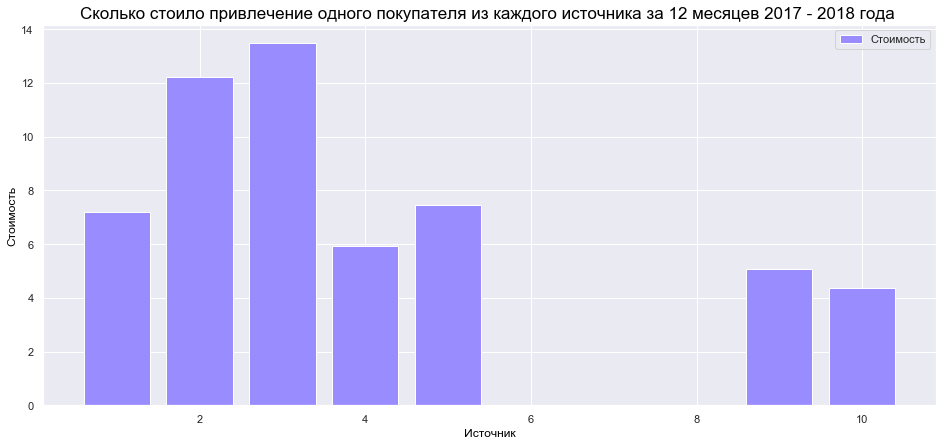

In [134]:
plt.figure(figsize=(16, 7))
plt.bar(cost_buyer_each_source['source_id'], cost_buyer_each_source['price_for_client'], color=(0.60, 0.55, 1));
plt.title('Сколько стоило привлечение одного покупателя из каждого источника за 12 месяцев 2017 - 2018 года ', fontsize=17, color='black')
plt.xlabel('Источник',fontsize=12, color='black')
plt.ylabel('Стоимость',fontsize=12, color='black')
plt.legend([ 'Стоимость']);

## На сколько окупились расходы? (ROI)
[--](https://praktikum.yandex.ru/trainer/data-analyst/lesson/866a6e6c-b9d9-495d-8815-1b42dfd4255f/task/d445cea6-6ca2-47c9-9cf5-134141fb1719/)


### Считаем

**- LTV (от англ. lifetime value) — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок**

**- CAC (от англ. customer acquisition cost) — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании**

**- ROMI - эта характеристика показывает эффективность проведенной рекламной кампании и окупаемость рекламных вложений В нашем случае все что больше 1 окупилось**

**Построим сводные таблицы расходов на маркетинг по каждого источнику, разобьем по месяцам**

In [135]:
sources = visit.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'}).reset_index()
display(sources.head())
#соединяем первые покупки и источники 
payers = order.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
display(payers.head())
payers = payers.rename(columns = {'buy_ts': 'first_buy'})

#считаем временные промежутки между первыми покупками
ltv = payers.merge(order, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)

#display(ltv.head(2))

#orders_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'count').fillna(0)
#buyers_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'uid', aggfunc = 'nunique').fillna(0)
#ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
display(ltv.head())


,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


,index,uid,buy_ts,source_id
0,0,313578113262317,2018-01-03 21:51:00,2
1,1,1575281904278712,2017-06-03 10:13:00,10
2,2,2429014661409475,2017-10-11 18:33:00,3
3,3,2464366381792757,2018-01-28 15:54:00,5
4,4,2551852515556206,2017-11-24 10:14:00,5


,index,uid,first_buy,source_id,buy_ts,revenue,order_month,lifetime
0,0,313578113262317,2018-01-03 21:51:00,2,2018-01-03 21:51:00,0.55,2018-01-01,0
1,1,1575281904278712,2017-06-03 10:13:00,10,2017-06-03 10:13:00,1.22,2017-06-01,0
2,1,1575281904278712,2017-06-03 10:13:00,10,2017-06-03 17:39:00,1.83,2017-06-01,0
3,2,2429014661409475,2017-10-11 18:33:00,3,2017-10-11 18:33:00,73.33,2017-10-01,0
4,3,2464366381792757,2018-01-28 15:54:00,5,2018-01-28 15:54:00,2.44,2018-01-01,0


**Построим сводную таблицу с суммой доходов из конкретного источника `source_id` за период времени `lifetime` промежуток времени когда клиентом была сделална первая покупка**	

In [136]:
report_ltv = ltv.groupby(['lifetime','source_id']).agg({'uid':'nunique', 'revenue': 'sum' }).reset_index()
report_ltv.columns = ['lifetime', 'source_id', 'n_buyers', 'revenue']
display(report_ltv.head())

,lifetime,source_id,n_buyers,revenue
0,0,1,2899,17846.78
1,0,2,3506,23737.70
2,0,3,10473,46894.89
3,0,4,10296,47204.71
4,0,5,6931,34030.40


**Посчитаем покупателей пришедших из каждого источника за все время**

In [137]:
report_ltv_n_buyers = report_ltv.groupby('source_id').agg({'n_buyers':'sum'}).reset_index()
report_ltv_n_buyers.columns = ['source_id', 'n_buyers_sum']
display(report_ltv_n_buyers.head(10))

,source_id,n_buyers_sum
0,1,3402
1,2,4228
2,3,11568
3,4,11308
4,5,7587
5,7,1
6,9,1375
7,10,1411


**Добавим столбец с общим доходом `gp` по умолчанию у нас 100%**

In [138]:
margin_rate = 1
report_ltv['gp'] = report_ltv ['revenue'] * margin_rate
display(report_ltv.head(22))

,lifetime,source_id,n_buyers,revenue,gp
0,0,1,2899,17846.78,17846.78
1,0,2,3506,23737.70,23737.70
2,0,3,10473,46894.89,46894.89
3,0,4,10296,47204.71,47204.71
4,0,5,6931,34030.40,34030.40
5,0,7,1,1.22,1.22
6,0,9,1088,4222.42,4222.42
7,0,10,1329,4205.13,4205.13
8,1,1,110,2883.49,2883.49
9,1,2,159,4502.22,4502.22


**Сджойним таблицу с общим количеством покупателей из каждого источника за весь период**


In [139]:
report_ltv = pd.merge(report_ltv, report_ltv_n_buyers, on='source_id')
report_ltv = report_ltv[report_ltv['lifetime'] <= 9 ]
display(report_ltv.head(22))

,lifetime,source_id,n_buyers,revenue,gp,n_buyers_sum
0,0,1,2899,17846.78,17846.78,3402
1,1,1,110,2883.49,2883.49,3402
2,2,1,92,2146.19,2146.19,3402
3,3,1,59,1874.49,1874.49,3402
4,4,1,57,1425.00,1425.00,3402
5,5,1,39,642.94,642.94,3402
6,6,1,45,796.48,796.48,3402
7,7,1,33,988.65,988.65,3402
8,8,1,23,940.43,940.43,3402
9,9,1,14,752.60,752.60,3402


**Добавим столбец с LTV итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок из каждого источника за период времени**

In [140]:
report_ltv['ltv'] = report_ltv['gp'] / report_ltv['n_buyers_sum']


In [141]:
output_ltv = report_ltv.pivot_table(index = 'source_id', columns = 'lifetime', values='ltv', aggfunc='mean')
output_ltv = output_ltv.cumsum(axis=1).round(2)

display(output_ltv)

lifetime,0,1,2,3,4,5,6,7,8,9
source_id,,,,,,,,,,
1,5.25,6.09,6.72,7.28,7.69,7.88,8.12,8.41,8.68,8.91
2,5.61,6.68,8.06,9.33,9.87,10.35,10.55,10.74,10.92,10.97
3,4.05,4.28,4.41,4.53,4.60,4.64,4.66,4.68,4.70,4.71
4,4.17,4.31,4.42,4.51,4.61,4.76,4.86,4.91,4.93,4.96
5,4.49,4.67,5.00,6.25,6.46,6.62,6.73,6.81,6.87,6.92
7,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.07,3.30,3.49,3.70,3.79,3.91,4.00,4.06,4.15,4.18
10,2.98,3.04,3.07,3.11,3.12,3.13,3.14,3.15,3.15,3.15


**Посчитаем CAC каждого источника . Сначала найдём суммарные расходы за каждый месяц, а затем поделим их на количество покупателей с каждого источника**

Посчитать CAC - сгруппировать costs по источникам и поделить на все то же количество покупателей из каждого источника за весь период.

**Cгруппируппируем `costs` по источникам и сумме полученного дохода**

In [142]:
source_id_costs = cost.groupby('source_id').sum()
display(source_id_costs.head(9))

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


**Соеденим таблицы**

In [143]:
report_cac = pd.merge(report_ltv, source_id_costs, on=['source_id'])
report_cac['cac'] = report_cac['costs'] / report_cac['n_buyers_sum']
display(report_cac.head(20))
#display(report_new['costs'].sum())

,lifetime,source_id,n_buyers,revenue,gp,n_buyers_sum,ltv,costs,cac
0,0,1,2899,17846.78,17846.78,3402,5.245967,20833.27,6.123830
1,1,1,110,2883.49,2883.49,3402,0.847587,20833.27,6.123830
2,2,1,92,2146.19,2146.19,3402,0.630861,20833.27,6.123830
3,3,1,59,1874.49,1874.49,3402,0.550996,20833.27,6.123830
4,4,1,57,1425.00,1425.00,3402,0.418871,20833.27,6.123830
5,5,1,39,642.94,642.94,3402,0.188989,20833.27,6.123830
6,6,1,45,796.48,796.48,3402,0.234121,20833.27,6.123830
7,7,1,33,988.65,988.65,3402,0.290608,20833.27,6.123830
8,8,1,23,940.43,940.43,3402,0.276434,20833.27,6.123830
9,9,1,14,752.60,752.60,3402,0.221223,20833.27,6.123830


In [144]:
output_cac = report_cac.pivot_table(index = 'source_id', columns = 'lifetime', values='cac', aggfunc='mean')


Чтобы посчитать накопительный ROMI, вызовем метод cumsum() (от англ. cumulative sum, «накапливаемая сумма»). 
Он последовательно складывает элементы множества. Например, pd.Series([1, 2, 3]).cumsum() вернёт серию из 3 элементов: 1, 3 и 6.
Каждое значение равно сумме предыдущих: 1, 3 = 1+2, 6 = 1+2+3.
`output_cac = output_cac.cumsum(axis=1).round(2) `


In [145]:
output_cac = output_cac.cumsum(axis=1).round(2) 
display(output_cac)

lifetime,0,1,2,3,4,5,6,7,8,9
source_id,,,,,,,,,,
1,6.12,12.25,18.37,24.50,30.62,36.74,42.87,48.99,55.11,61.24
2,10.12,20.25,30.37,40.50,50.62,60.75,70.87,81.00,91.12,101.24
3,12.22,24.43,36.65,48.87,61.08,73.30,85.52,97.73,109.95,122.17
4,5.40,10.80,16.20,21.60,27.00,32.41,37.81,43.21,48.61,54.01
5,6.82,13.64,20.47,27.29,34.11,40.93,47.75,54.57,61.40,68.22
9,4.01,8.03,12.04,16.05,20.06,24.08,28.09,32.10,36.11,40.13
10,4.13,8.25,12.38,16.51,20.63,24.76,28.89,33.01,37.14,41.26


**Посчитаем `ROMI` когда окупаются рекламные компании**

In [146]:
report_cac['romi'] = report_cac['ltv'] / report_cac['cac']
display(report_cac.head())

,lifetime,source_id,n_buyers,revenue,gp,n_buyers_sum,ltv,costs,cac,romi
0,0,1,2899,17846.78,17846.78,3402,5.245967,20833.27,6.12383,0.856648
1,1,1,110,2883.49,2883.49,3402,0.847587,20833.27,6.12383,0.138408
2,2,1,92,2146.19,2146.19,3402,0.630861,20833.27,6.12383,0.103017
3,3,1,59,1874.49,1874.49,3402,0.550996,20833.27,6.12383,0.089976
4,4,1,57,1425.00,1425.00,3402,0.418871,20833.27,6.12383,0.068400


In [147]:
output_romi = report_cac.pivot_table(index = 'source_id', columns = 'lifetime', values='romi', aggfunc='mean')
output_romi = output_romi.cumsum(axis=1).round(2) 
display(output_romi)

lifetime,0,1,2,3,4,5,6,7,8,9
source_id,,,,,,,,,,
1,0.86,1.00,1.10,1.19,1.26,1.29,1.33,1.37,1.42,1.45
2,0.55,0.66,0.80,0.92,0.97,1.02,1.04,1.06,1.08,1.08
3,0.33,0.35,0.36,0.37,0.38,0.38,0.38,0.38,0.38,0.39
4,0.77,0.80,0.82,0.83,0.85,0.88,0.90,0.91,0.91,0.92
5,0.66,0.68,0.73,0.92,0.95,0.97,0.99,1.00,1.01,1.01
9,0.77,0.82,0.87,0.92,0.94,0.97,1.00,1.01,1.03,1.04
10,0.72,0.74,0.74,0.75,0.76,0.76,0.76,0.76,0.76,0.76


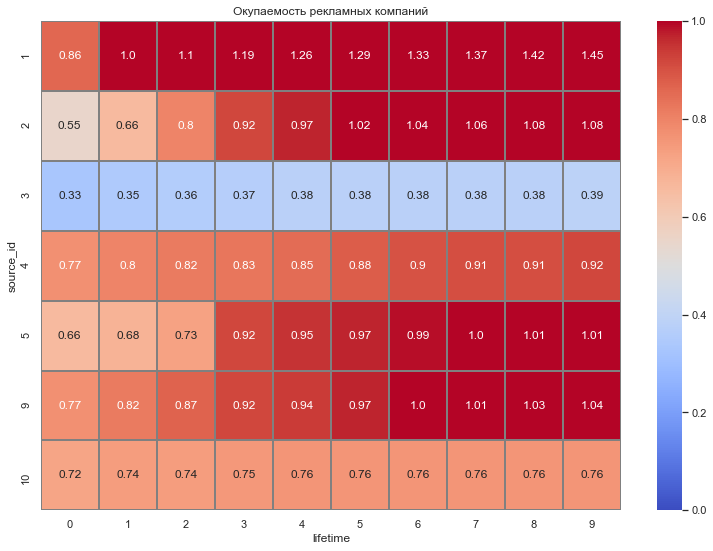

In [148]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Окупаемость рекламных компаний')
sns.heatmap(output_romi, annot=True, fmt='.3', linewidths=1, linecolor='gray', vmin = 0, vmax = 1, 
            cmap = 'coolwarm');

<div class="alert alert-info">
    
### Узнаем, как быстро в среднем компании окупаются.   
</div>

In [149]:
output_romi.cumsum(axis=1).mean(axis=0) 

lifetime
0    0.665714
1    1.387143
2    2.161429
3    3.004286
4    3.877143
5    4.772857
6    5.687143
7    6.614286
8    7.555714
9    8.505714
dtype: float64

<div class="alert alert-info">
    
**V3 Поправим, вывод и формулу**
</div>

In [150]:
output_romi.mean(axis=0)

lifetime
0    0.665714
1    0.721429
2    0.774286
3    0.842857
4    0.872857
5    0.895714
6    0.914286
7    0.927143
8    0.941429
9    0.950000
dtype: float64

# Вывод: В среднем компания близка с 6-7 месяца к окупаемости, но за счет самых проблемные по окуппаемости 3 и 10 рекламных компаний, в среднем не окупается.

<div class="alert alert-info">

### Выбрал 9 месяцев чтобы полностью вошли все рекламные компании
</div>

# Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

### Посмотрим окупаемость на разных устройствах

In [151]:
display(visit.head(2))

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration,duration_min_int,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,00:18:00,18,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,00:28:00,28,2018-02-19 16:53:00,2018-02-01,2018-02-01,0


### Отсортируем таблицу по тому какие устройства использовались для доступа к афише

In [152]:
visit_device_touch = visit[visit['device'] == 'touch']
display(visit_device_touch.head(2))
visit_device_desktop = visit[visit['device'] == 'desktop']
display(visit_device_desktop.head(2))

,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration,duration_min_int,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,2017,00:18:00,18,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,2017,00:00:00,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0


,device,end_ts,source_id,start_ts,uid,day,week,month,year,duration,duration_min_int,first_activity_date,activity_month,first_activity_month,cohort_lifetime
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,2018,00:28:00,28,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,20,5,2018,00:24:00,24,2018-03-09 20:05:00,2018-05-01,2018-03-01,2


### Начнем с дивайсов `touch`

In [153]:
sources = visit_device_touch.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'}).reset_index()
#соединяем первые покупки и источники 
payers = order.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})
#считаем временные промежутки между первыми покупками
ltv = payers.merge(order, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)


In [154]:
report_ltv = ltv.groupby(['lifetime','source_id']).agg({'uid':'nunique', 'revenue': 'sum' }).reset_index()
report_ltv.columns = ['lifetime', 'source_id', 'n_buyers', 'revenue']


In [155]:
report_ltv_n_buyers = report_ltv.groupby('source_id').agg({'n_buyers':'sum'}).reset_index()
report_ltv_n_buyers.columns = ['source_id', 'n_buyers_sum']


In [156]:
margin_rate = 1
report_ltv['gp'] = report_ltv ['revenue'] * margin_rate


In [157]:
report_ltv = pd.merge(report_ltv, report_ltv_n_buyers, on='source_id')


In [158]:
report_ltv['ltv'] = report_ltv['gp'] / report_ltv['n_buyers_sum']



In [159]:
source_id_costs = cost.groupby('source_id').sum()


In [160]:
report_cac = pd.merge(report_ltv, source_id_costs, on=['source_id'])
report_cac['cac'] = report_cac['costs'] / report_cac['n_buyers_sum']


In [161]:
report_cac['romi'] = report_cac['ltv'] / report_cac['cac']
display(report_cac.head())

,lifetime,source_id,n_buyers,revenue,gp,n_buyers_sum,ltv,costs,cac,romi
0,0,1,765,5211.01,5211.01,889,5.861654,20833.27,23.434499,0.250129
1,1,1,29,774.17,774.17,889,0.870832,20833.27,23.434499,0.037160
2,2,1,29,381.93,381.93,889,0.429618,20833.27,23.434499,0.018333
3,3,1,11,75.14,75.14,889,0.084522,20833.27,23.434499,0.003607
4,4,1,18,84.89,84.89,889,0.095489,20833.27,23.434499,0.004075


In [162]:
output_romi = report_cac.pivot_table(index = 'source_id', columns = 'lifetime', values='romi', aggfunc='mean')
output_romi = output_romi.cumsum(axis=1).round(2) 
display(output_romi)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.25,0.29,0.31,0.31,0.31,0.31,0.32,0.32,0.32,0.32,0.32,0.32,0.32
2,0.20,0.23,0.25,0.27,0.29,0.30,0.31,0.31,0.32,0.32,0.33,0.33,0.33
3,0.07,0.07,0.08,0.08,0.08,0.08,0.09,0.09,0.09,0.09,0.09,0.09,0.09
4,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.29,0.29,0.30,0.30,0.30,0.30
5,0.12,0.12,0.12,0.12,0.13,0.13,0.13,0.13,0.13,0.13,0.13,NaN,NaN
9,0.24,0.25,0.26,0.27,0.27,0.28,0.28,0.28,0.29,0.29,0.29,0.29,NaN
10,0.16,0.17,0.17,0.17,0.17,0.17,NaN,0.17,0.17,NaN,NaN,NaN,NaN


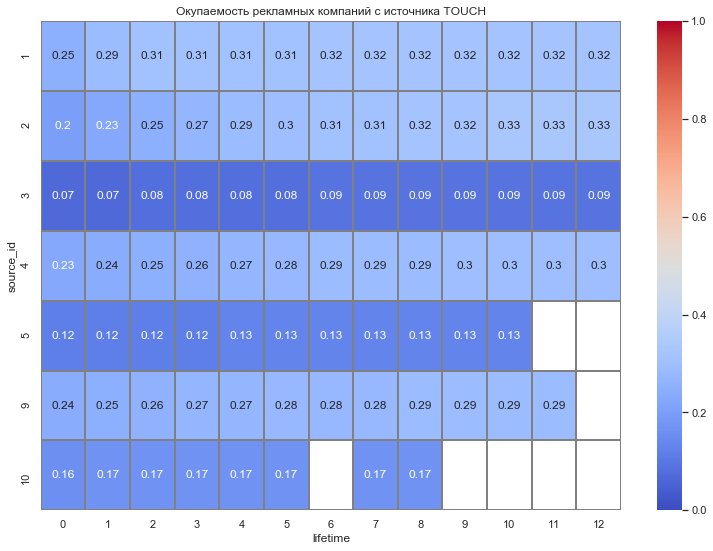

In [163]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Окупаемость рекламных компаний с источника TOUCH')
sns.heatmap(output_romi, annot=True, fmt='.3', linewidths=1, linecolor='gray', vmin = 0, vmax = 1, 
            cmap = 'coolwarm');

# Вывод: компании в которые люди приходят с мобильных устройств не окупаются.

### Посчитаем окупаемость `desktop`

In [164]:
sources = visit_device_desktop.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'}).reset_index()
#соединяем первые покупки и источники 
payers = order.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})
#считаем временные промежутки между первыми покупками
ltv = payers.merge(order, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)

report_ltv = ltv.groupby(['lifetime','source_id']).agg({'uid':'nunique', 'revenue': 'sum' }).reset_index()
report_ltv.columns = ['lifetime', 'source_id', 'n_buyers', 'revenue']

report_ltv_n_buyers = report_ltv.groupby('source_id').agg({'n_buyers':'sum'}).reset_index()
report_ltv_n_buyers.columns = ['source_id', 'n_buyers_sum']

margin_rate = 1
report_ltv['gp'] = report_ltv ['revenue'] * margin_rate

report_ltv = pd.merge(report_ltv, report_ltv_n_buyers, on='source_id')
report_ltv['ltv'] = report_ltv['gp'] / report_ltv['n_buyers_sum']
source_id_costs = cost.groupby('source_id').sum()
report_cac = pd.merge(report_ltv, source_id_costs, on=['source_id'])
report_cac['cac'] = report_cac['costs'] / report_cac['n_buyers_sum']
report_cac['romi'] = report_cac['ltv'] / report_cac['cac']
output_romi = report_cac.pivot_table(index = 'source_id', columns = 'lifetime', values='romi', aggfunc='mean')
output_romi = output_romi.cumsum(axis=1).round(2) 
display(output_romi)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.70,0.81,0.91,1.00,1.07,1.10,1.14,1.19,1.23,1.27,1.28,1.30,1.31
2,0.49,0.60,0.75,0.87,0.93,0.99,1.01,1.03,1.05,1.05,1.06,1.07,1.07
3,0.30,0.31,0.32,0.33,0.34,0.34,0.34,0.35,0.35,0.35,0.35,0.35,0.35
4,0.62,0.64,0.65,0.67,0.69,0.70,0.72,0.72,0.73,0.73,0.74,0.74,0.74
5,0.58,0.60,0.65,0.83,0.86,0.88,0.90,0.91,0.92,0.93,0.93,0.93,0.93
9,0.67,0.73,0.78,0.83,0.85,0.88,0.90,0.92,0.94,0.95,0.95,NaN,NaN
10,0.60,0.61,0.62,0.63,0.63,0.63,0.64,0.64,0.64,0.64,NaN,NaN,NaN


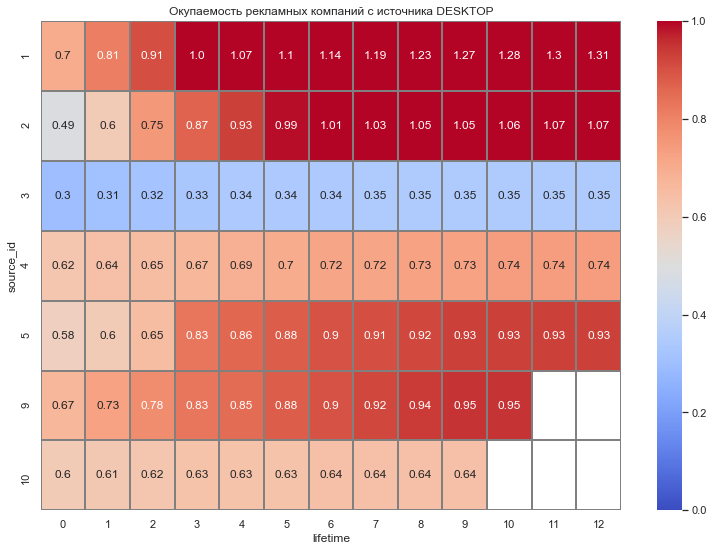

In [165]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Окупаемость рекламных компаний c источника DESKTOP')
sns.heatmap(output_romi, annot=True, fmt='.3', linewidths=1, linecolor='gray', vmin = 0, vmax = 1, 
            cmap = 'coolwarm');

# Вывод: десктопная версия афиши окупается гораздо лучше мобильной, вложения в первую рекламную компанию окупились уже на второй месяц. самые проблемные по окупаемости 3 и 10 рекламная компании.

# Общий вывод: 
## - основываясь на показателях romi, мы видим проблемы окупаемости 3 и 10 рекламной компании
## - основываясь на показателях romi, мы видим проблемы окупаемости рекламных команий на которые приходят с мобильных устройств.

# Рекомендации маркетологам:
## 1. Закрыть или глубоко преработать рекламные компании 3 и 10 как нерентабельные на прошедший год
## 2. Переработать мобильное приложение и обратить внимание на отображение сайта на мобильных устройствах. Хотя мобильные приложения как правило огоняют по частоте использования десктопные версии у нас наблюдается обратная картина.
